In [4]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(rlang)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)
library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
library(ggplot2)
library(survminer)
library(muhaz)
library(dplyr)
library(stringr)
options(warn=-1)
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(broom)
library(logistf)
library(ggfortify)
source('tools.R')
source('../../src/tools.R')     # custom tools function
source('../../src/hdp_tools_yanis.R')
source("../../src/merge_df.R")
source("../../src/my_toolbox.R")
source("../../src/my_components.R")
source("../../src/my_utils.R")
source("../../src/ggstyles.R")
source("../../src/my_hotspots.R")

###


# theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

In [3]:
colors_analysis <- c(gen="#BFBFBF",cyto="#2b8cbe")
val = c("#EE9937","#5C5C5C","#870C14","#BFBFBF","#59A08B","#2b8cbe","#a6bddb","#fdbb84","#e79f00","#000000","darkseagreen","lightskyblue","#0072B2","pink","blue","green")

df_w_correlates <- read.table("../clustering/clustering_Final_1/df_final_full_component.tsv")
df_final <- read.table("../clustering/clustering_Final_1/df_final_full_component.tsv")

cols_order <- c("t_15_17","inv_16","t_8_21","t_11","t_6_9","inv_3","additions","TP53_complex","NPM1","CEBPA_bi","DNMT3A_IDH1_2","WT1","chr_splicing_multiple","chr_splicing_1","not_assigned","no_events")

genes <- colnames(df_final[,c(5:88)])

cytos <- colnames(df_final[,c(89:158)])

eln <- colnames(df_final[,c(2,3,4)])
comp <- colnames(df_final[,c(170:186)])

all_gen <- c(5:88)
vect <- apply(X=df_final[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
gen <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])

all_cyto <- c(89:158)
vect <- apply(X=df_final[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
cyto <- colnames(df_final[,match(names(vect[vect>=2]),names(df_final))])

clin <- colnames(df_final[,c(159:165)])
demo <- colnames(df_final[,c(166:167)])
pal <- c(eln="#EE9937",comp="#59A08B",gen="#BFBFBF",cyto="#2b8cbe",clin="#870C14",demo="#a6bddb",age="#a6bddb",gen_cyto="pink",eln_gen_cyto="#fdbb84",comp_gen_cyto="lightgoldenrod",all="lightsalmon")  
colors <- c("black","gray1","grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
"#9ad0f3", "#D55E00", 
"lightgoldenrod","lightskyblue","#F0E442",
"firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen","purple","forestgreen","gray2")
              
### Color Components ###
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))

color_values <- c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7","#9ad0f3", "#D55E00", "lightgoldenrod","lightskyblue","#F0E442",
                  "firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen",
                  "purple","forestgreen")
tmp <- NULL
for (co in cols_component){
    tmp1 <- df_w_correlates[df_w_correlates[,co]==1,]
    tmp1$comparison <- str_remove(co,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }
tmp$fill_pal <- factor(tmp$comparison)
names(color_values) <- levels(factor(tmp$fill_pal))
color_values["overlap"] <- "purple"

# I) Cohort Caracteristics

# I.2) Unique genotypes in AML Dataset

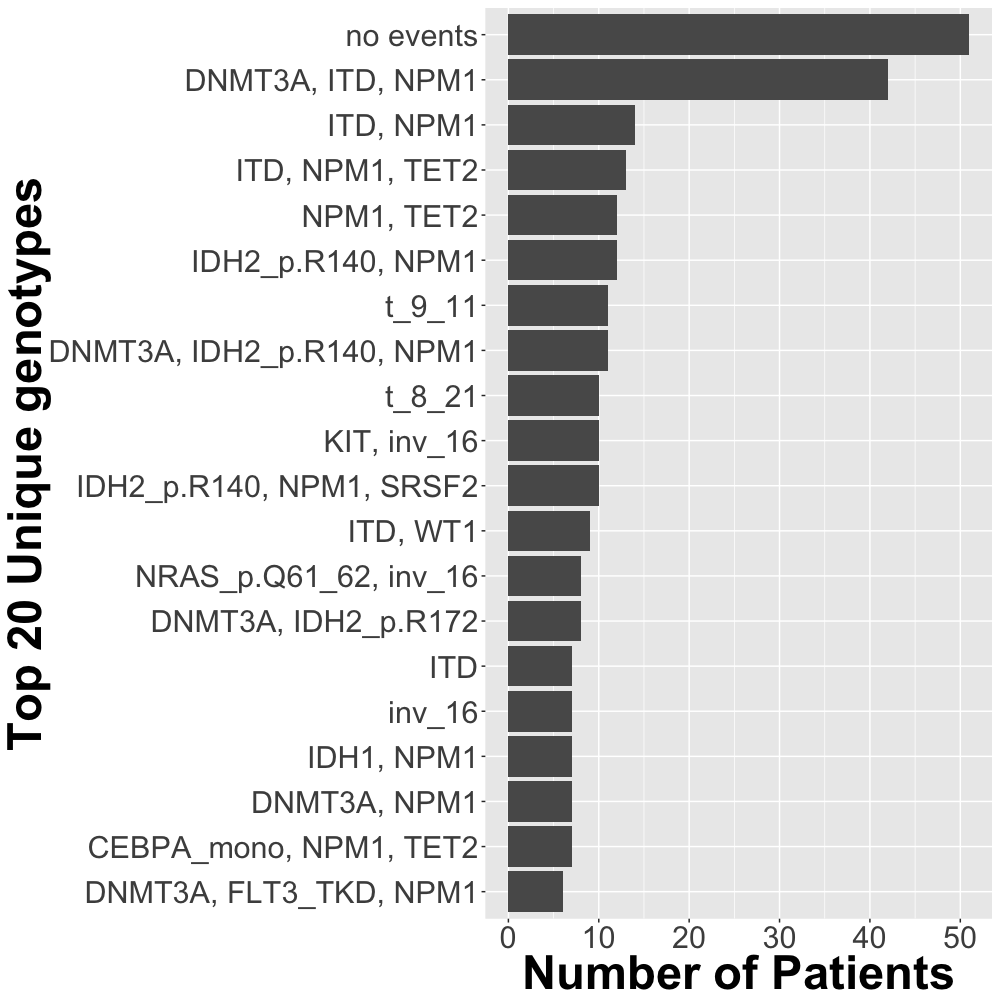

In [10]:
# png("figures/unique_genotypes.png",width=4500,height=2500,res=200)
set_notebook_plot_size(10,10)
unique_genotypes(df_final,features=c(genes,cytos),top=20)
# dev.off()

# I.3) Patients classification according to ELN 2017

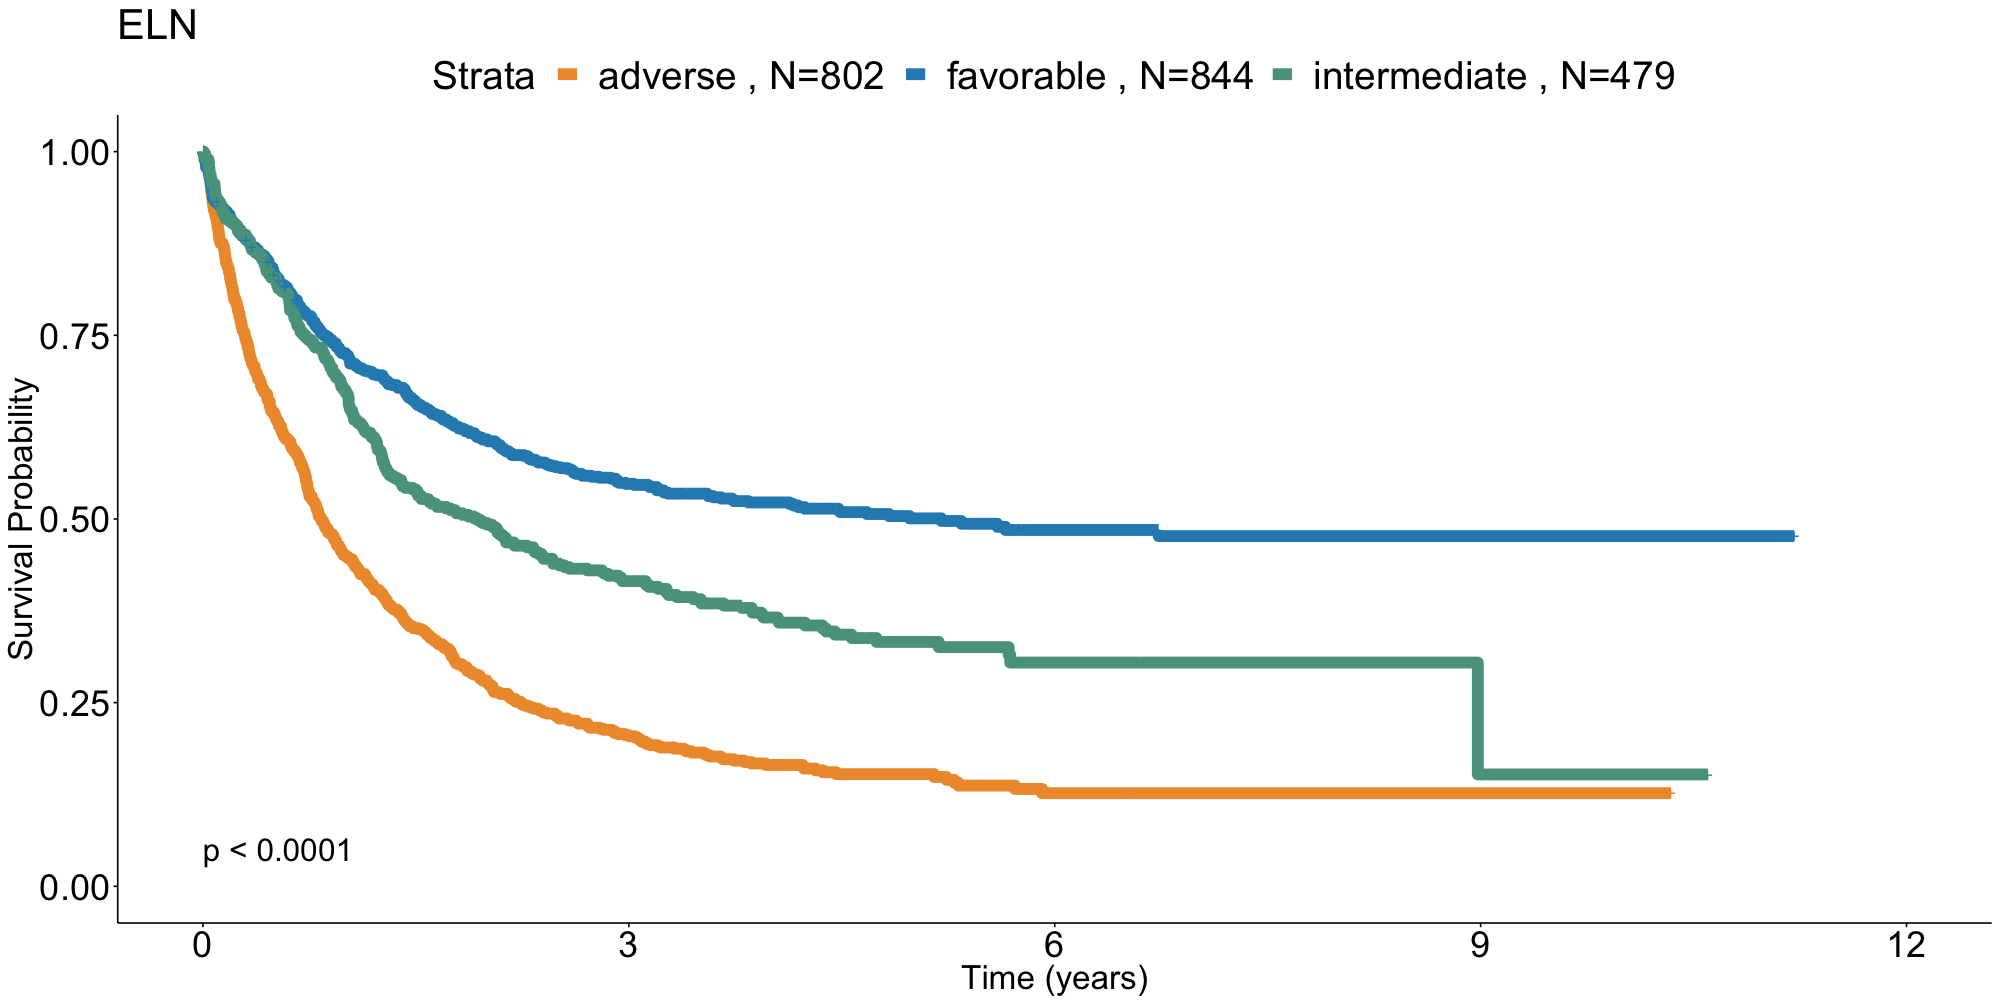

In [12]:
# png("figures/eln_surv.png",width=3000,height=1500,res=200)
set_notebook_plot_size(20,10)
tmp <- df_w_correlates
tmp$comparison <- ifelse(tmp$eln_2017_favorable==1,"favorable",
                        ifelse(tmp$eln_2017_intermediate==1,"intermediate","adverse"))
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
plot_surv_curves(fit,legend="top",submain="ELN",vals=c("#EE9937","#2b8cbe","#59A08B"),y="Survival Probability")

# dev.off()

# I.4) Patients stratification by Age

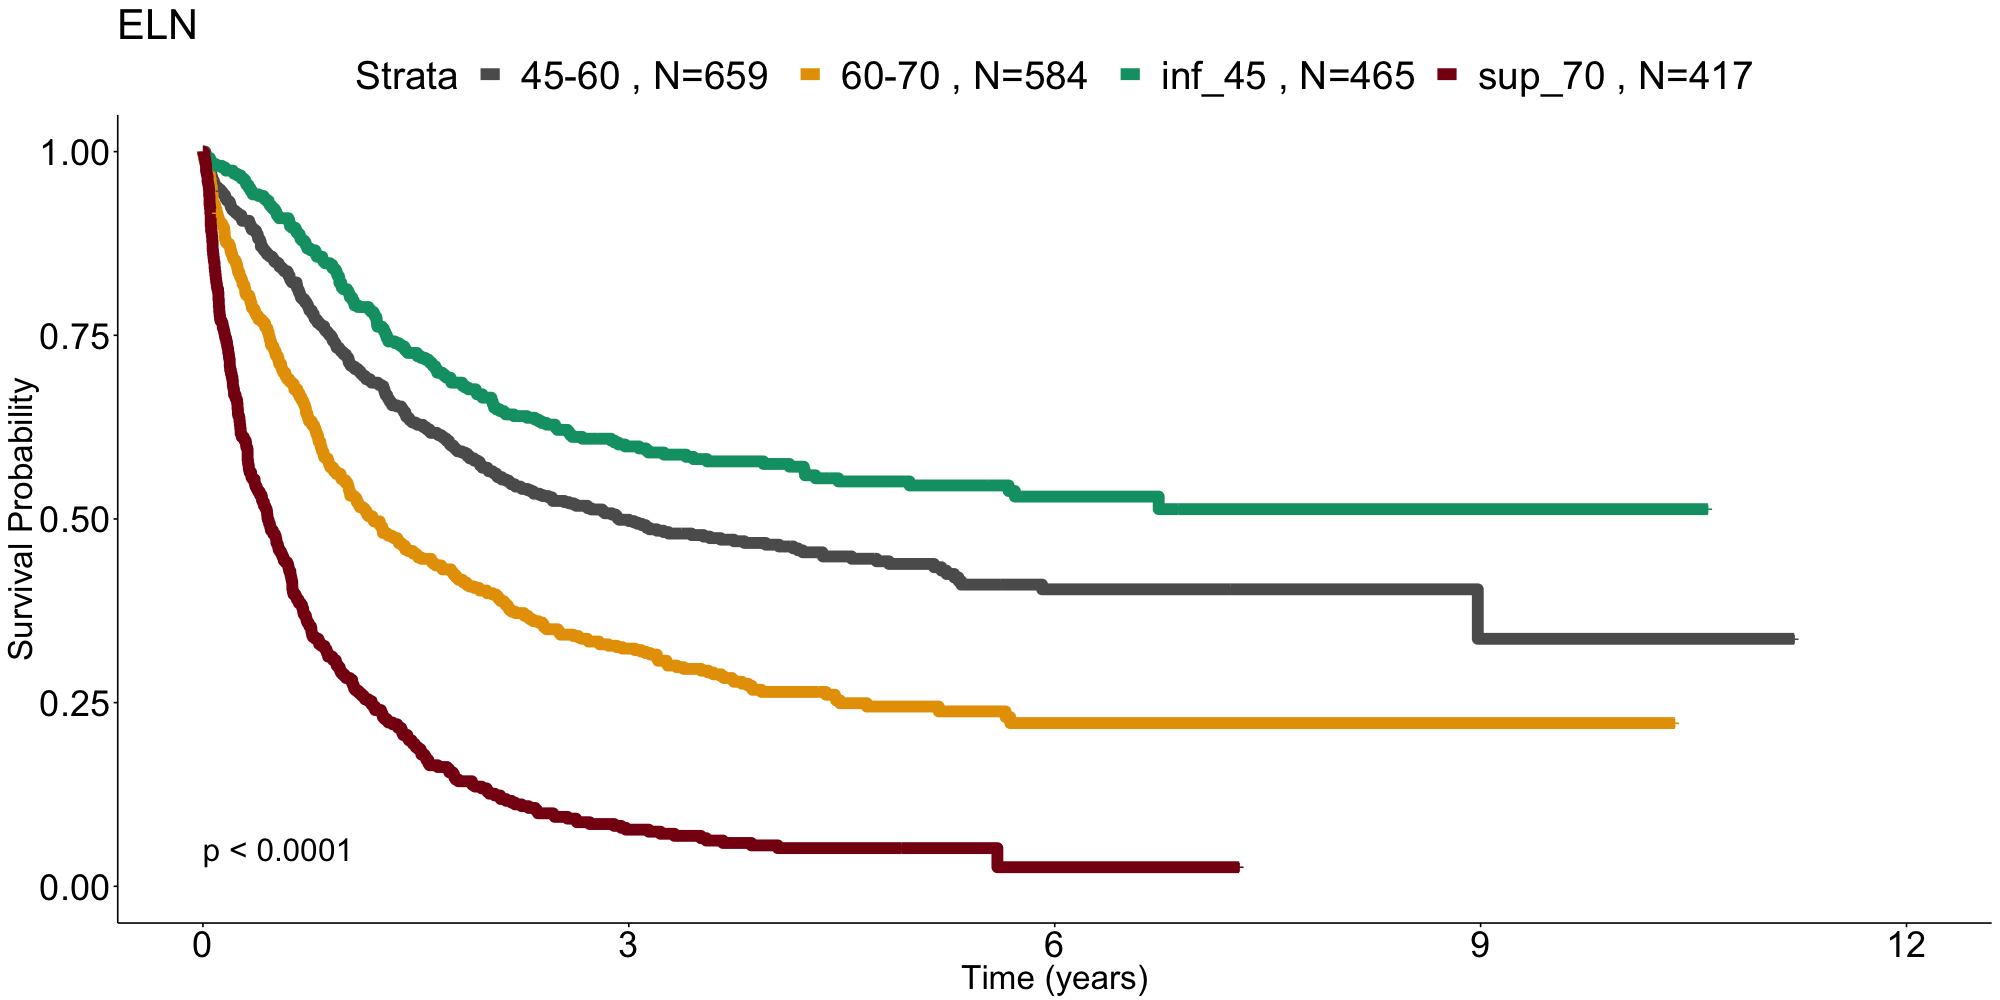

In [14]:
# png("figures/age_surv.png",width=3000,height=2000,res=200)
tmp <- df_w_correlates
tmp$comparison <- ifelse(tmp$age<45,"inf_45",
                        ifelse(tmp$age>=45 & tmp$age<60,"45-60",
                        ifelse(tmp$age>=60 & tmp$age<70,"60-70","sup_70")))
fit <- survfit(surv_object ~ comparison, data = tmp)
plot_surv_curves(fit,legend="top",submain="ELN",vals=c("#5C5C5C","#e79f00","#009E73","#870C14"),y="Survival Probability")
# dev.off()

# I.5) Overall Freqency Stratified by ELN

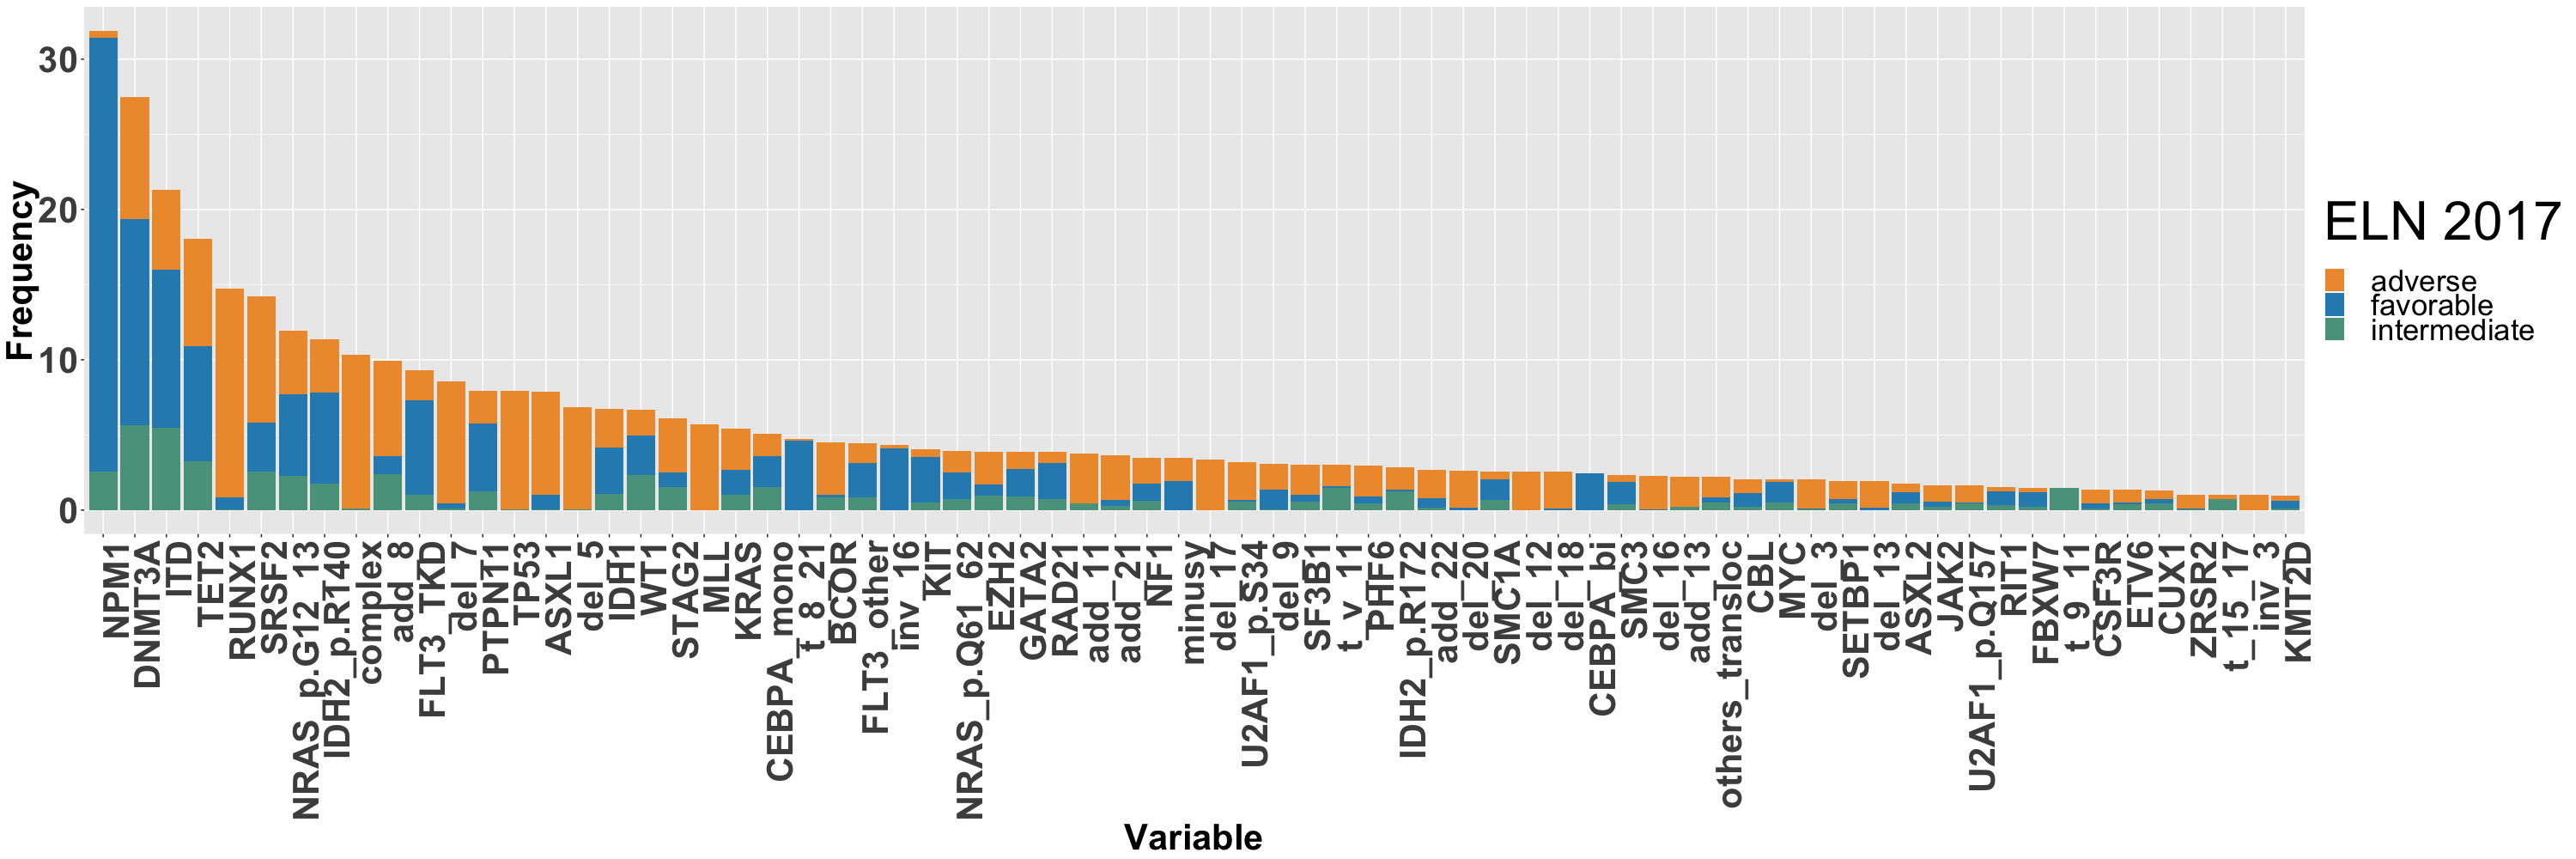

In [18]:
# png("figures/overall_strat_freq.png",width=6000,height=4000,res=200)
set_notebook_plot_size(30,10)
overall_strat_frequency(df_final,top=70)
# dev.off()

# I.6) Risk by # of Mutations and cyto alt

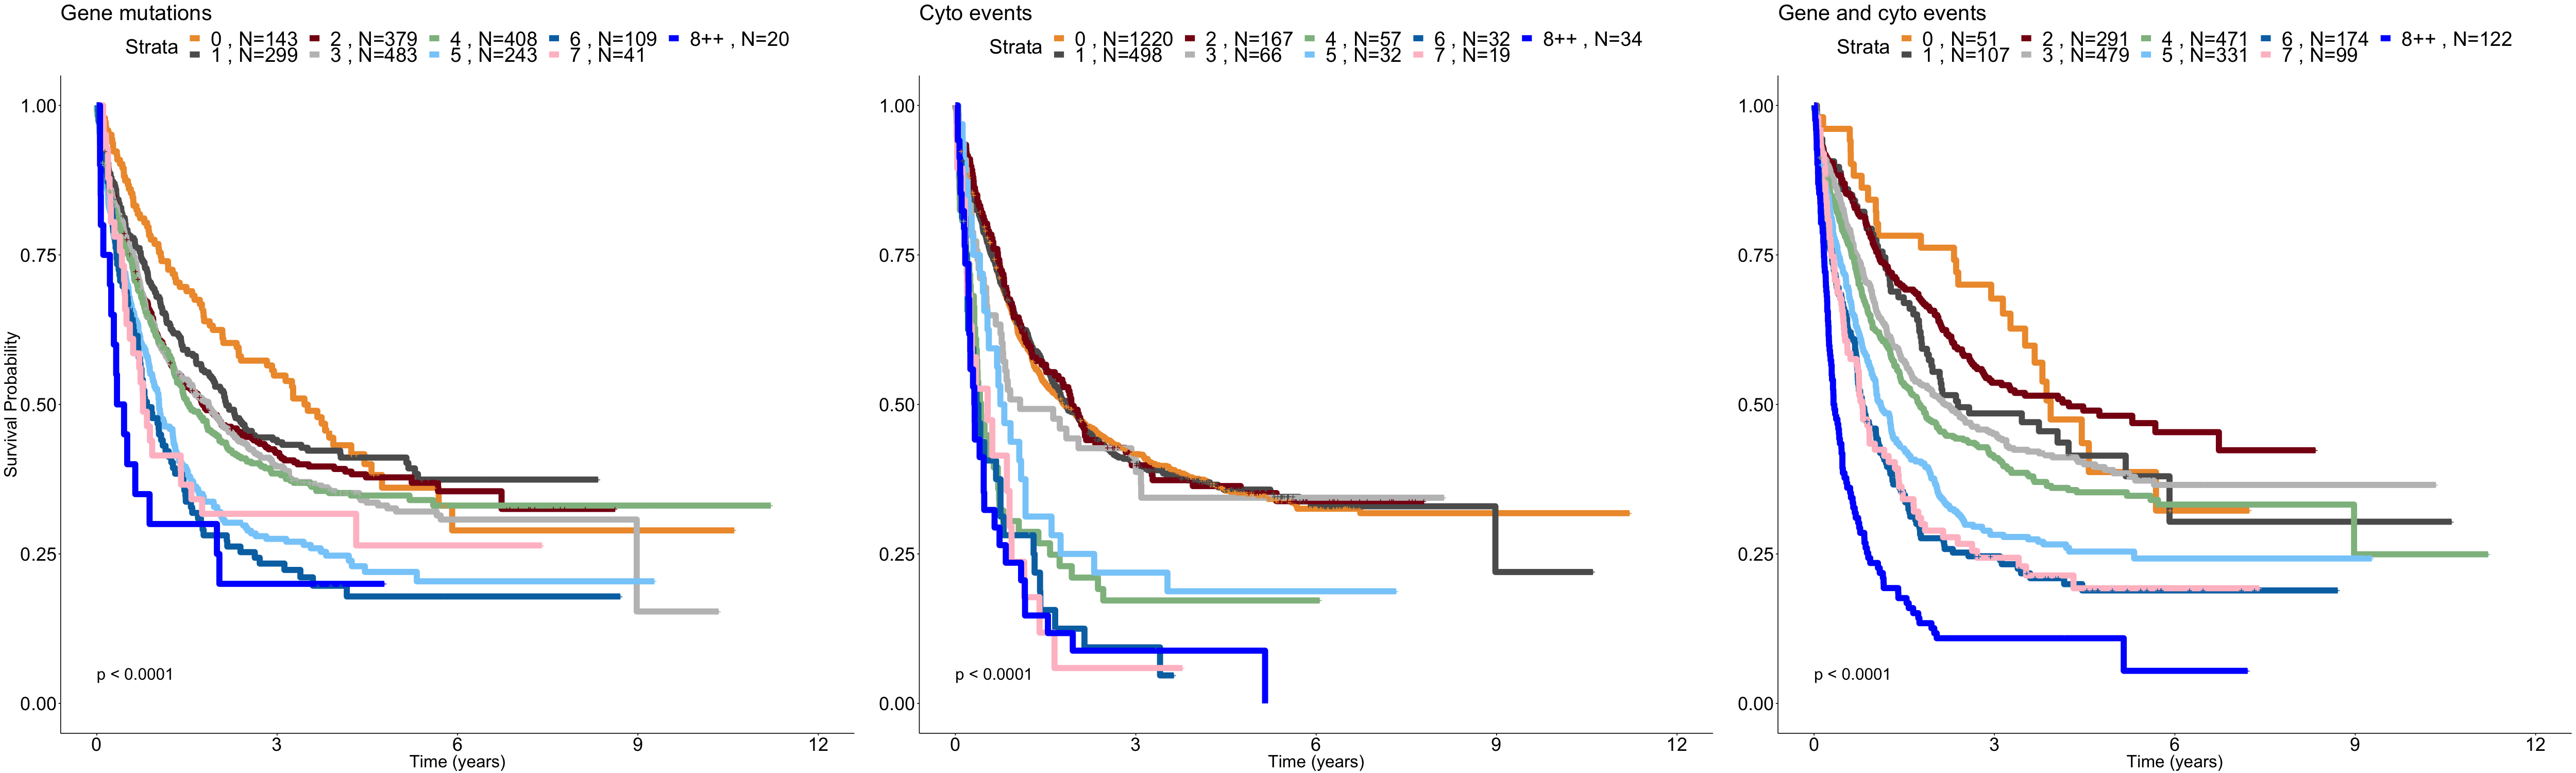

In [20]:
# png("figures/gene_cyto_surv.png",width=11200,height=2200,res=260)
set_notebook_plot_size(50,15)

tmp <- df_w_correlates
tmp$genes <- rowSums(tmp[,c(genes)])
tmp$cytos <- rowSums(tmp[,c(cytos)])
tmp$total <- rowSums(tmp[,c(genes,cytos)])

### genes
tmp[tmp$genes>=8,"genes"] <- "8++"
tmp$comparison <- tmp$genes

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,legend="top",
                           vals=c("#EE9937","#5C5C5C","#870C14","#BFBFBF","darkseagreen","lightskyblue","#0072B2","pink","blue","green"),submain="Gene mutations",risk.tab=T,y="Survival Probability")

### cytos
tmp[tmp$cytos>=8,"cytos"] <- "8++"
tmp$comparison <- tmp$cytos

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,legend="top",
                           vals=c("#EE9937","#5C5C5C","#870C14","#BFBFBF","darkseagreen","lightskyblue","#0072B2","pink","blue","green"),submain="Cyto events",risk.tab=T)

### cytos
tmp[tmp$total>=8,"total"] <- "8++"
tmp$comparison <- tmp$total

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
r <- plot_surv_curves(fit,legend="top",
                           vals=c("#EE9937","#5C5C5C","#870C14","#BFBFBF","darkseagreen","lightskyblue","#0072B2","pink","blue","green","grey45"),submain="Gene and cyto events",risk.tab=T)

grid.arrange(p$plot,q$plot,r$plot,nrow=1)
# dev.off()

# II ) Genotype Clinical Relationships

# II.1) Multivariate regression correlates

# A) Gender

In [21]:
set_notebook_plot_size(20,10)

png("figures/gender_lasso.png",width=4500,height=2500,res=200)
p <-  multivariate_regression(df_final,target="gender",features=c(gen,cyto),fam="binomial")
dev.off()

png("figures/gender_univariate.png",width=4500,height=2500,res=300)
q <- univariate_volcano(df_final,target="gender",features=c(gen,cyto),type="binary",quantile=c(0,0.98),p_value_threshold = 0.05)
dev.off()

pdf 
  2

pdf 
  2

# B) Age

In [22]:
set_notebook_plot_size(20,10)

png("figures/age_lasso.png",width=4500,height=2500,res=200)
p <-  multivariate_regression(df_final,target="age",features=c(gen,cyto),fam="gaussian")
dev.off()

png("figures/age_univariate.png",width=4500,height=2500,res=300)
q <- univariate_volcano(df_final,target="age",features=c(gen,cyto),type="continuous",quantile=c(0,1),p_value_threshold = 0.05)
dev.off()

pdf 
  2

pdf 
  2

# C) BM BLASTS

In [23]:
set_notebook_plot_size(20,10)

png("figures/bm_blasts_lasso.png",width=4500,height=2500,res=200)
p <-  multivariate_regression(df_final,target="bm_blasts",features=c(gen,cyto),fam="gaussian")
dev.off()

png("figures/bm_blasts_univariate.png",width=4500,height=2500,res=300)
q <- univariate_volcano(df_final,target="bm_blasts",features=c(gen,cyto),type="continuous",quantile=c(0,1),p_value_threshold = 0.05)
dev.off()

pdf 
  2

pdf 
  2

# D) PLT

In [24]:
png("figures/plt_lasso.png",width=4500,height=2500,res=200)
p <-  multivariate_regression(df_final,target="plt",features=c(gen,cyto),fam="gaussian")
dev.off()

png("figures/plt_univariate.png",width=4500,height=2500,res=300)
q <- univariate_volcano(df_final,target="plt",features=c(gen,cyto),type="continuous",quantile=c(0,1),p_value_threshold = 0.05)
dev.off()

pdf 
  2

pdf 
  2

# E) WBC

In [25]:
png("figures/wbc_lasso.png",width=4500,height=2500,res=200)
p <-  multivariate_regression(df_final,target="wbc",features=c(gen,cyto),fam="gaussian")
dev.off()

png("figures/wbc_univariate.png",width=4500,height=2500,res=300)
q <- univariate_volcano(df_final,target="wbc",features=c(gen,cyto),type="continuous",quantile=c(0,1),p_value_threshold = 0.05)
dev.off()

pdf 
  2

pdf 
  2

## III) Molecular Interactions

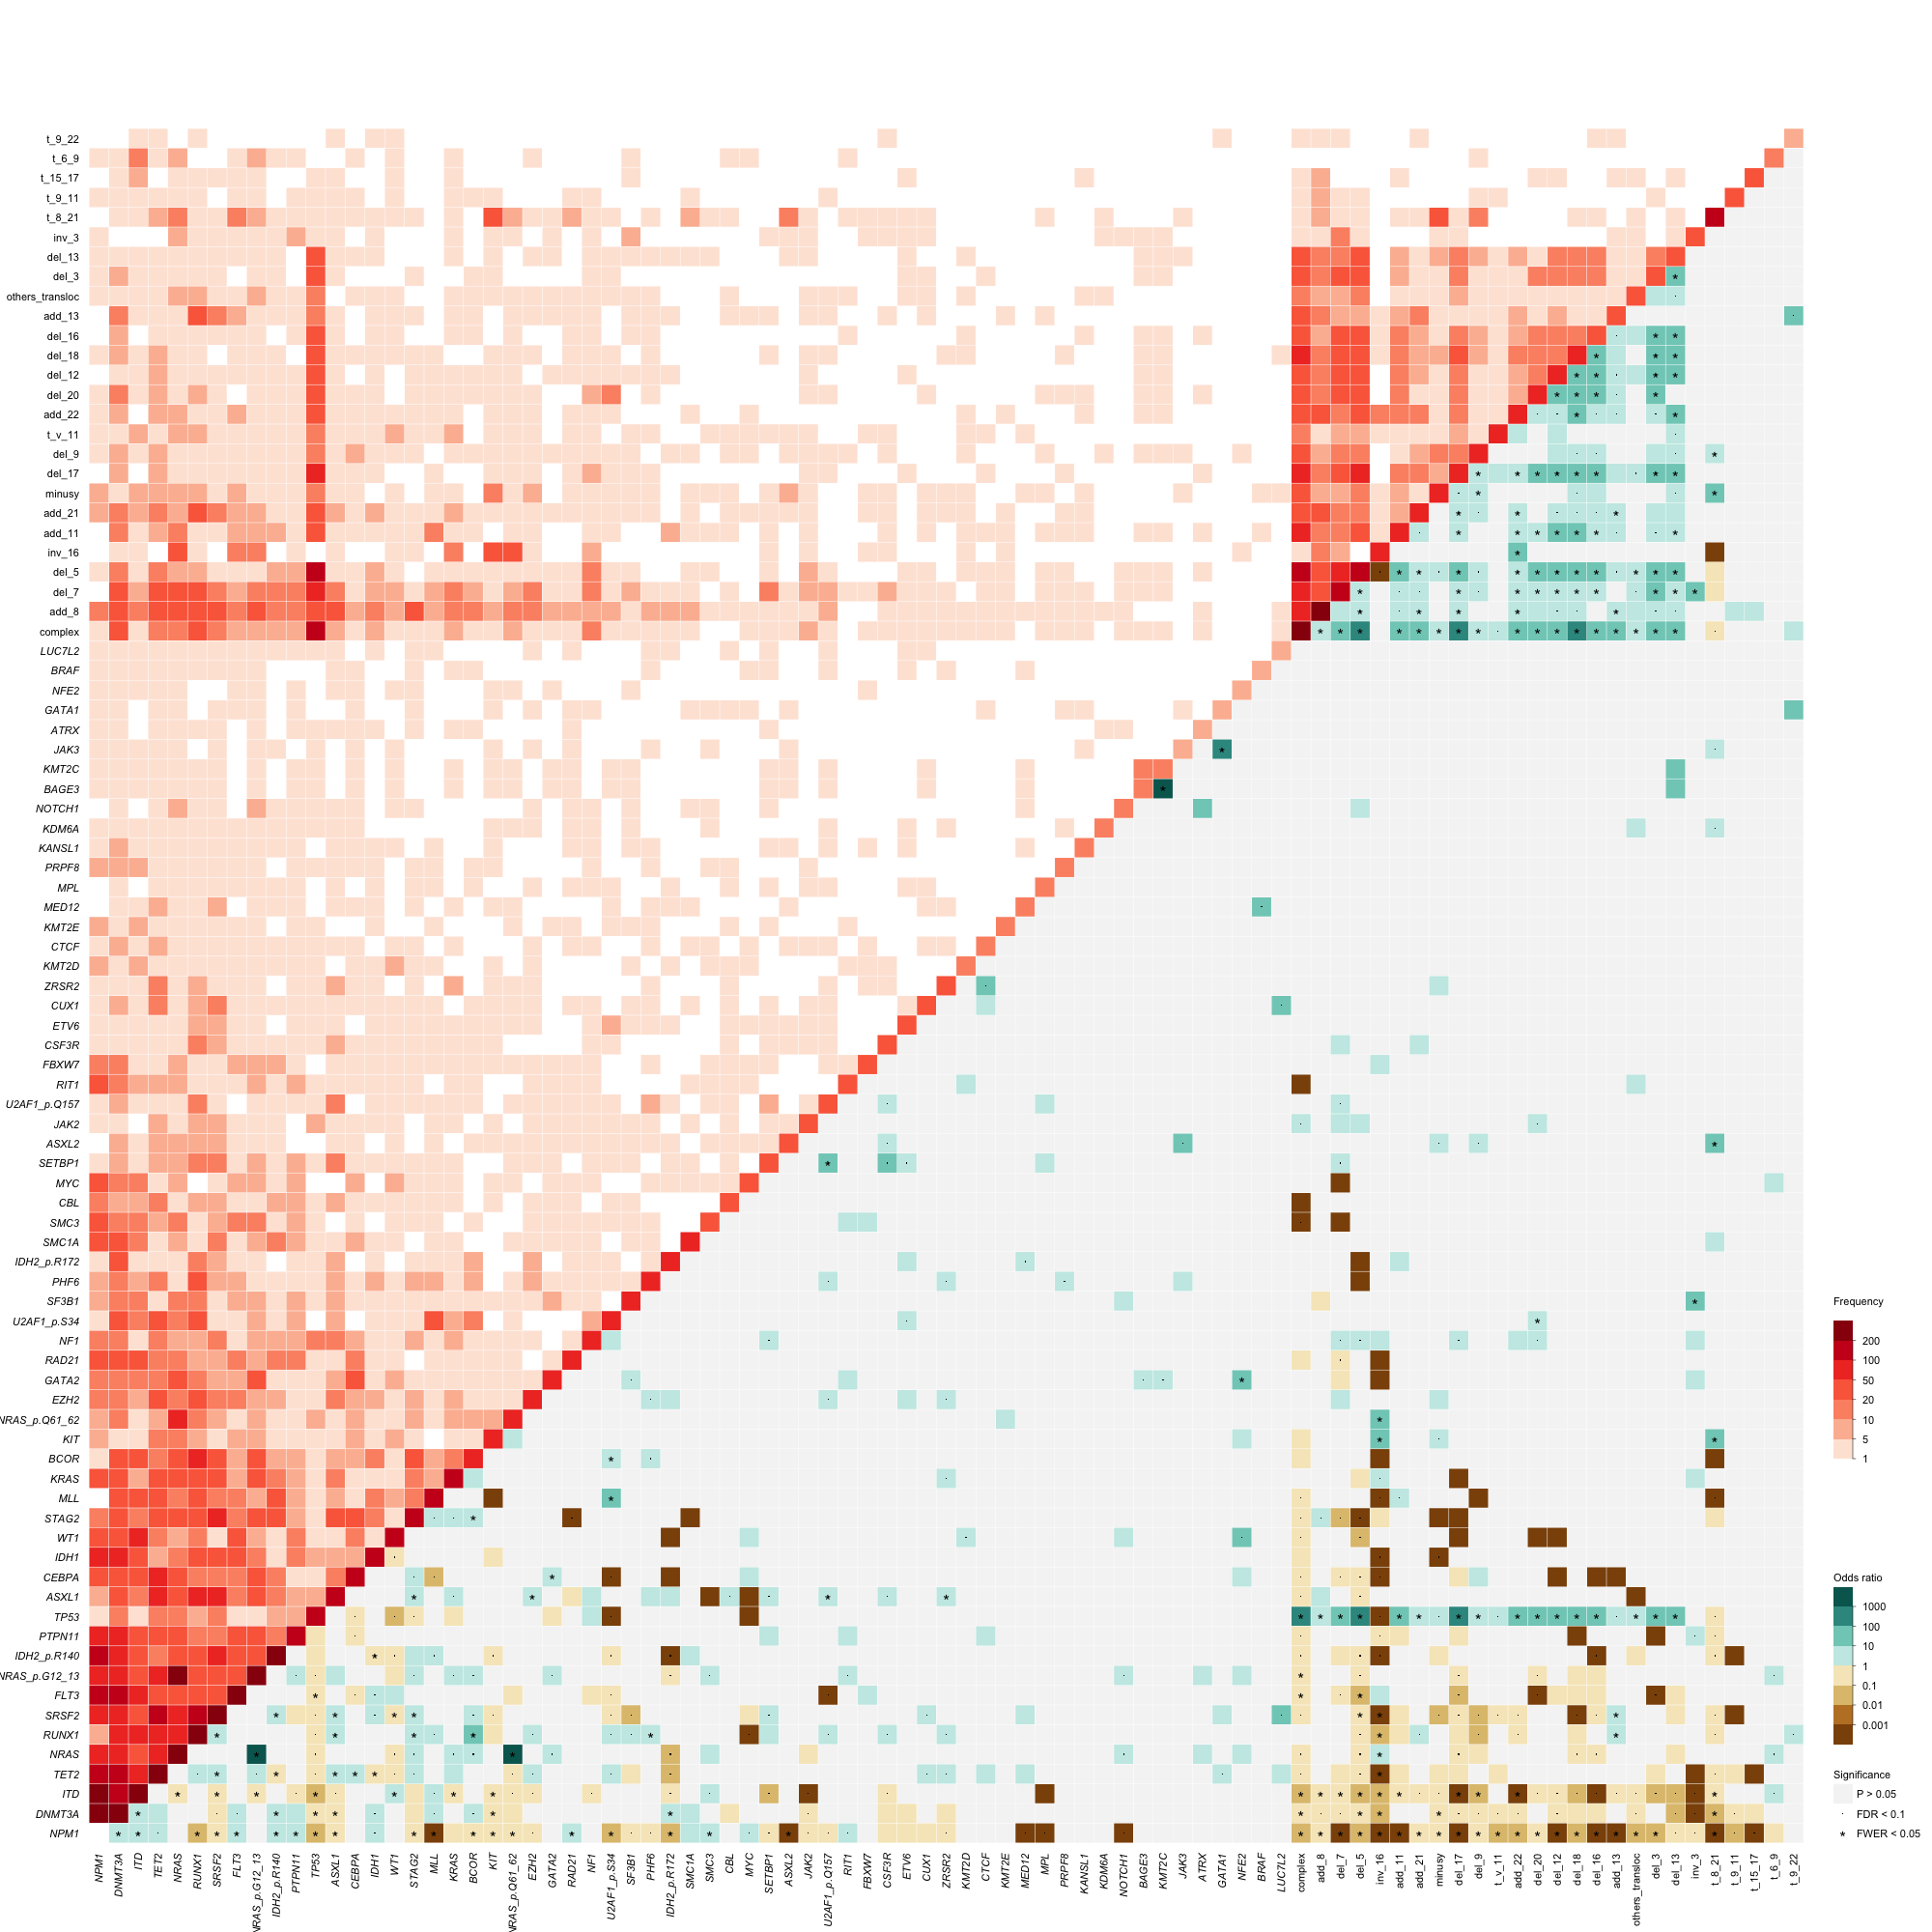

In [27]:
# png("figures/gene_gene_interaction.png",width=3000,height=3000,res=250)
set_notebook_plot_size(20,20)
gene_gene_interactions(df_final)
# dev.off()

# IV) COMPONENTS ANALYSIS

# IV.1) Component repartition

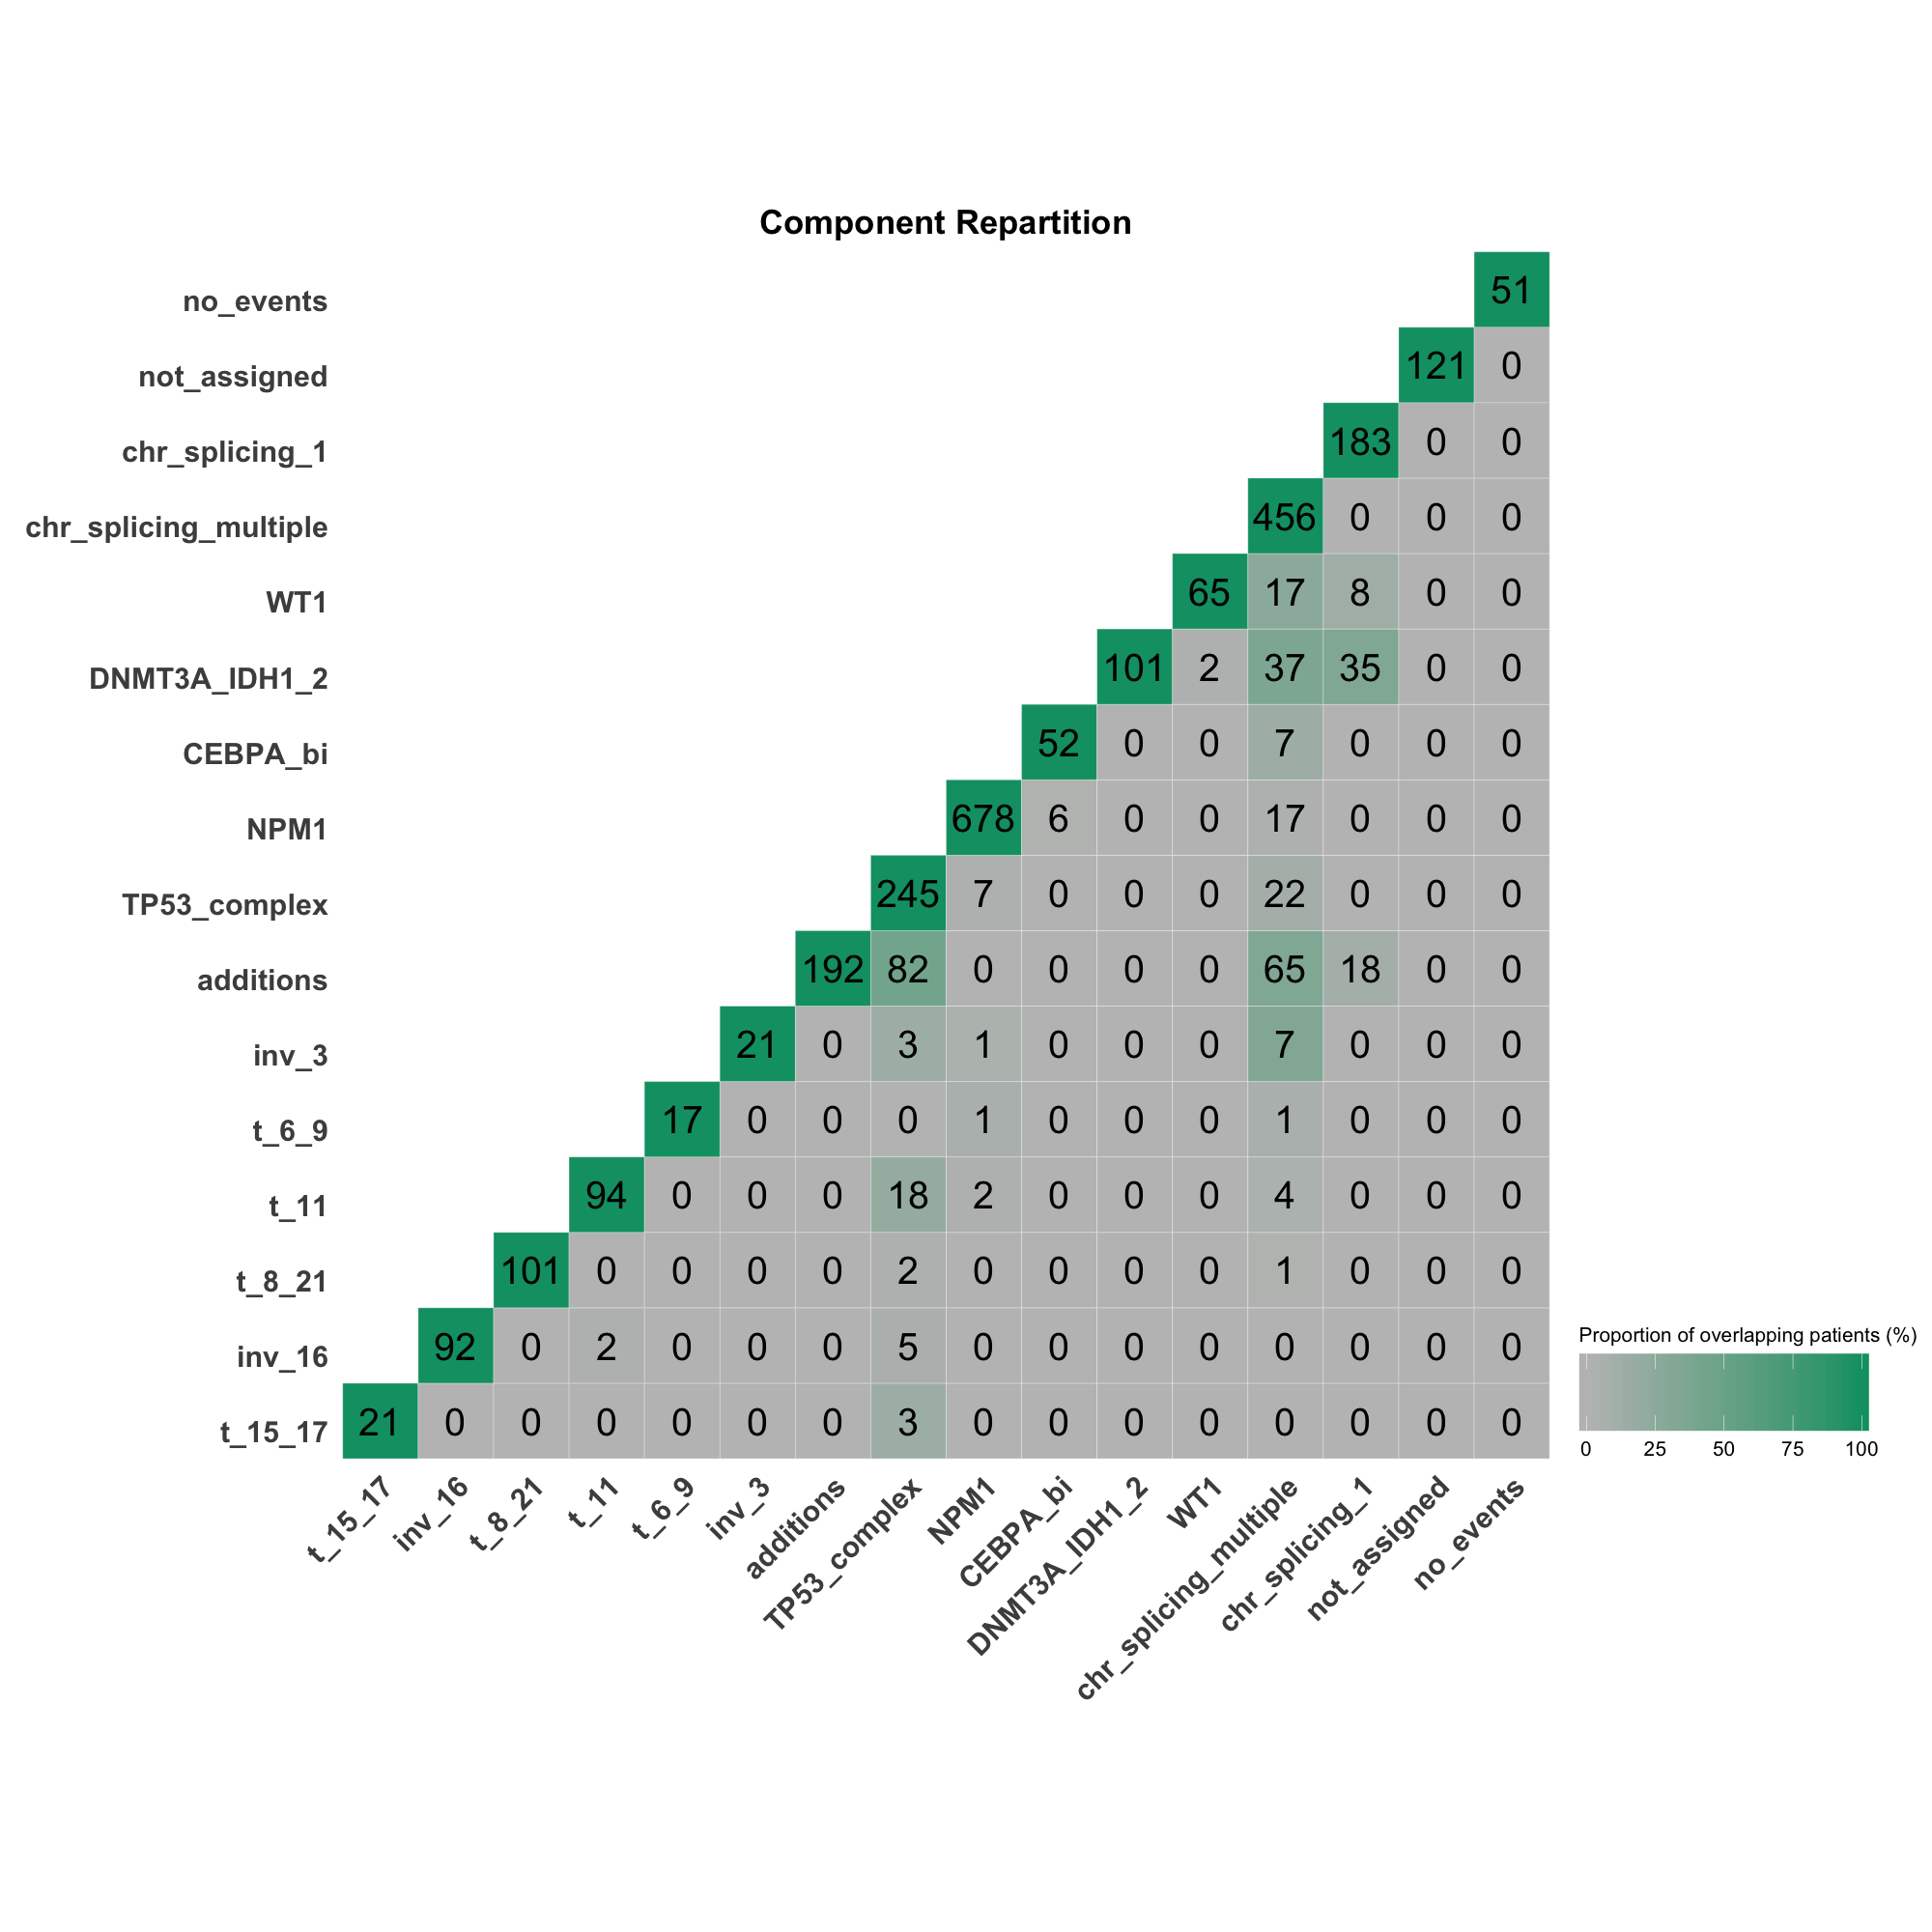

In [33]:
# png("figures/comp_repartition.png",width=4500,height=4500,res=200)
comp_repartition(df_final,cols_component,cols_order=cols_order)
# dev.off()

# IV.2) Components Stacked Frequency

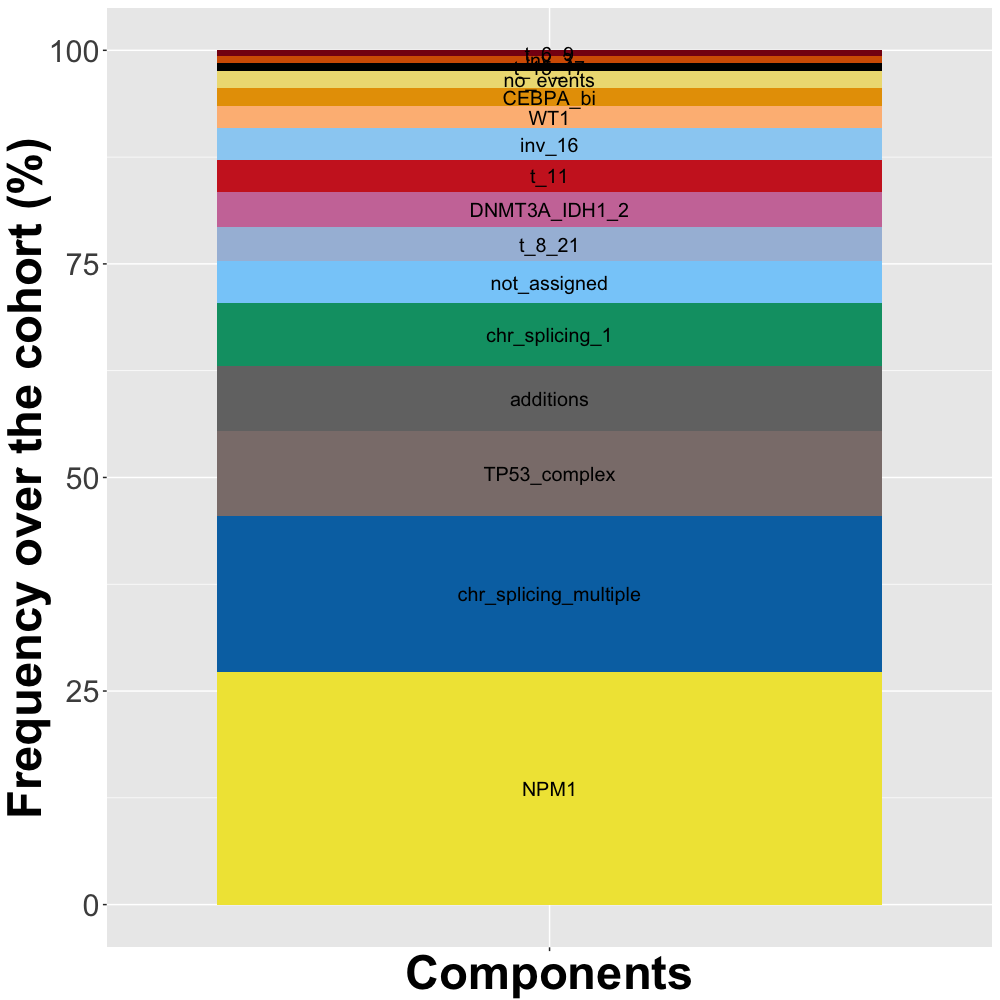

In [35]:
set_notebook_plot_size(10,10)
# png("figures/comp_frequency_stacked.png",width=1200,height=500)
comp_stacked_frequency(df_final,cols_component,color_values)
# dev.off()

# IV.3) Components Stacked by Age

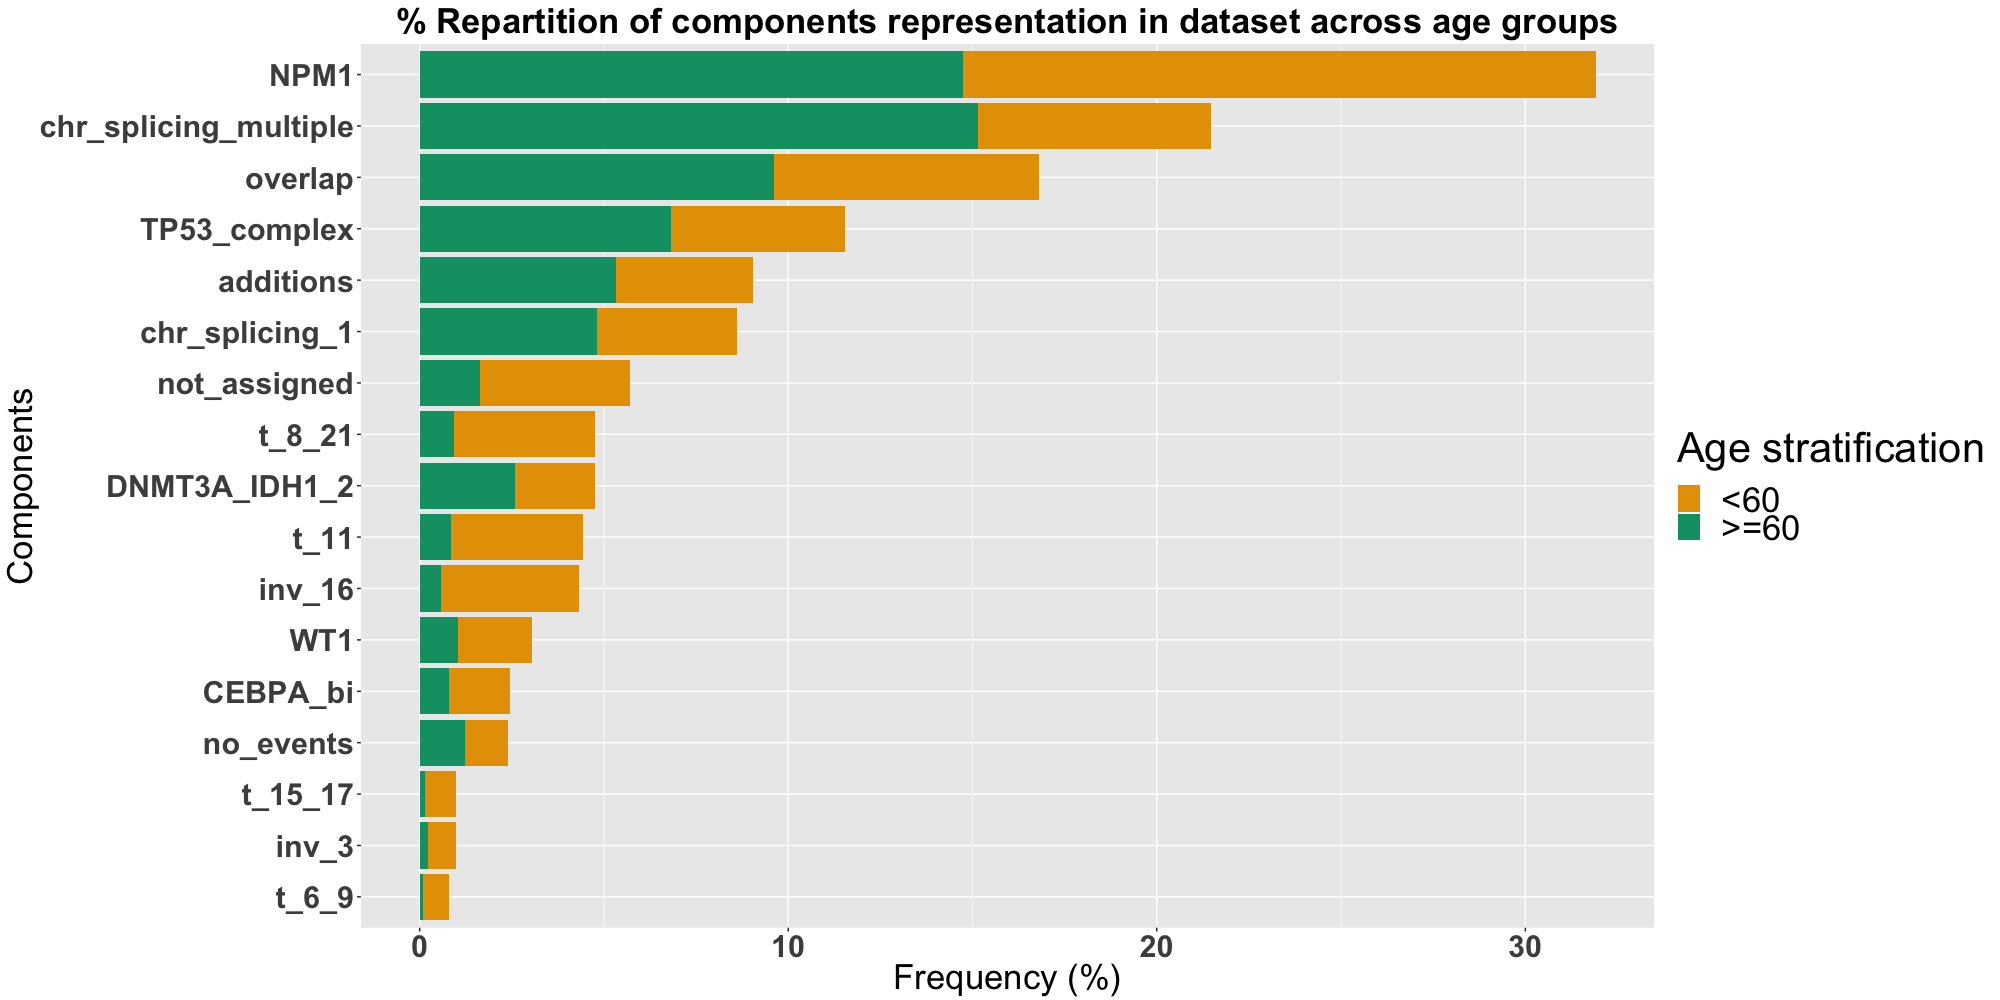

In [37]:
# png("figures/comp_frequency_age_groups.png",width=5000,height=4500,res=250)
set_notebook_plot_size(20,10)
comp_frequency_by_age(df_final,comp)
# dev.off()

# IV.4) Heatmaps Components Comparison

Order of Components : 
t_15_17  , inv_16  , t_8_21  , t_11  , t_6_9  , inv_3  , additions  , TP53_complex  , NPM1  , CEBPA_bi  , DNMT3A_IDH1_2  , WT1  , chr_splicing_multiple  , chr_splicing_1  , not_assigned  , no_events  ,

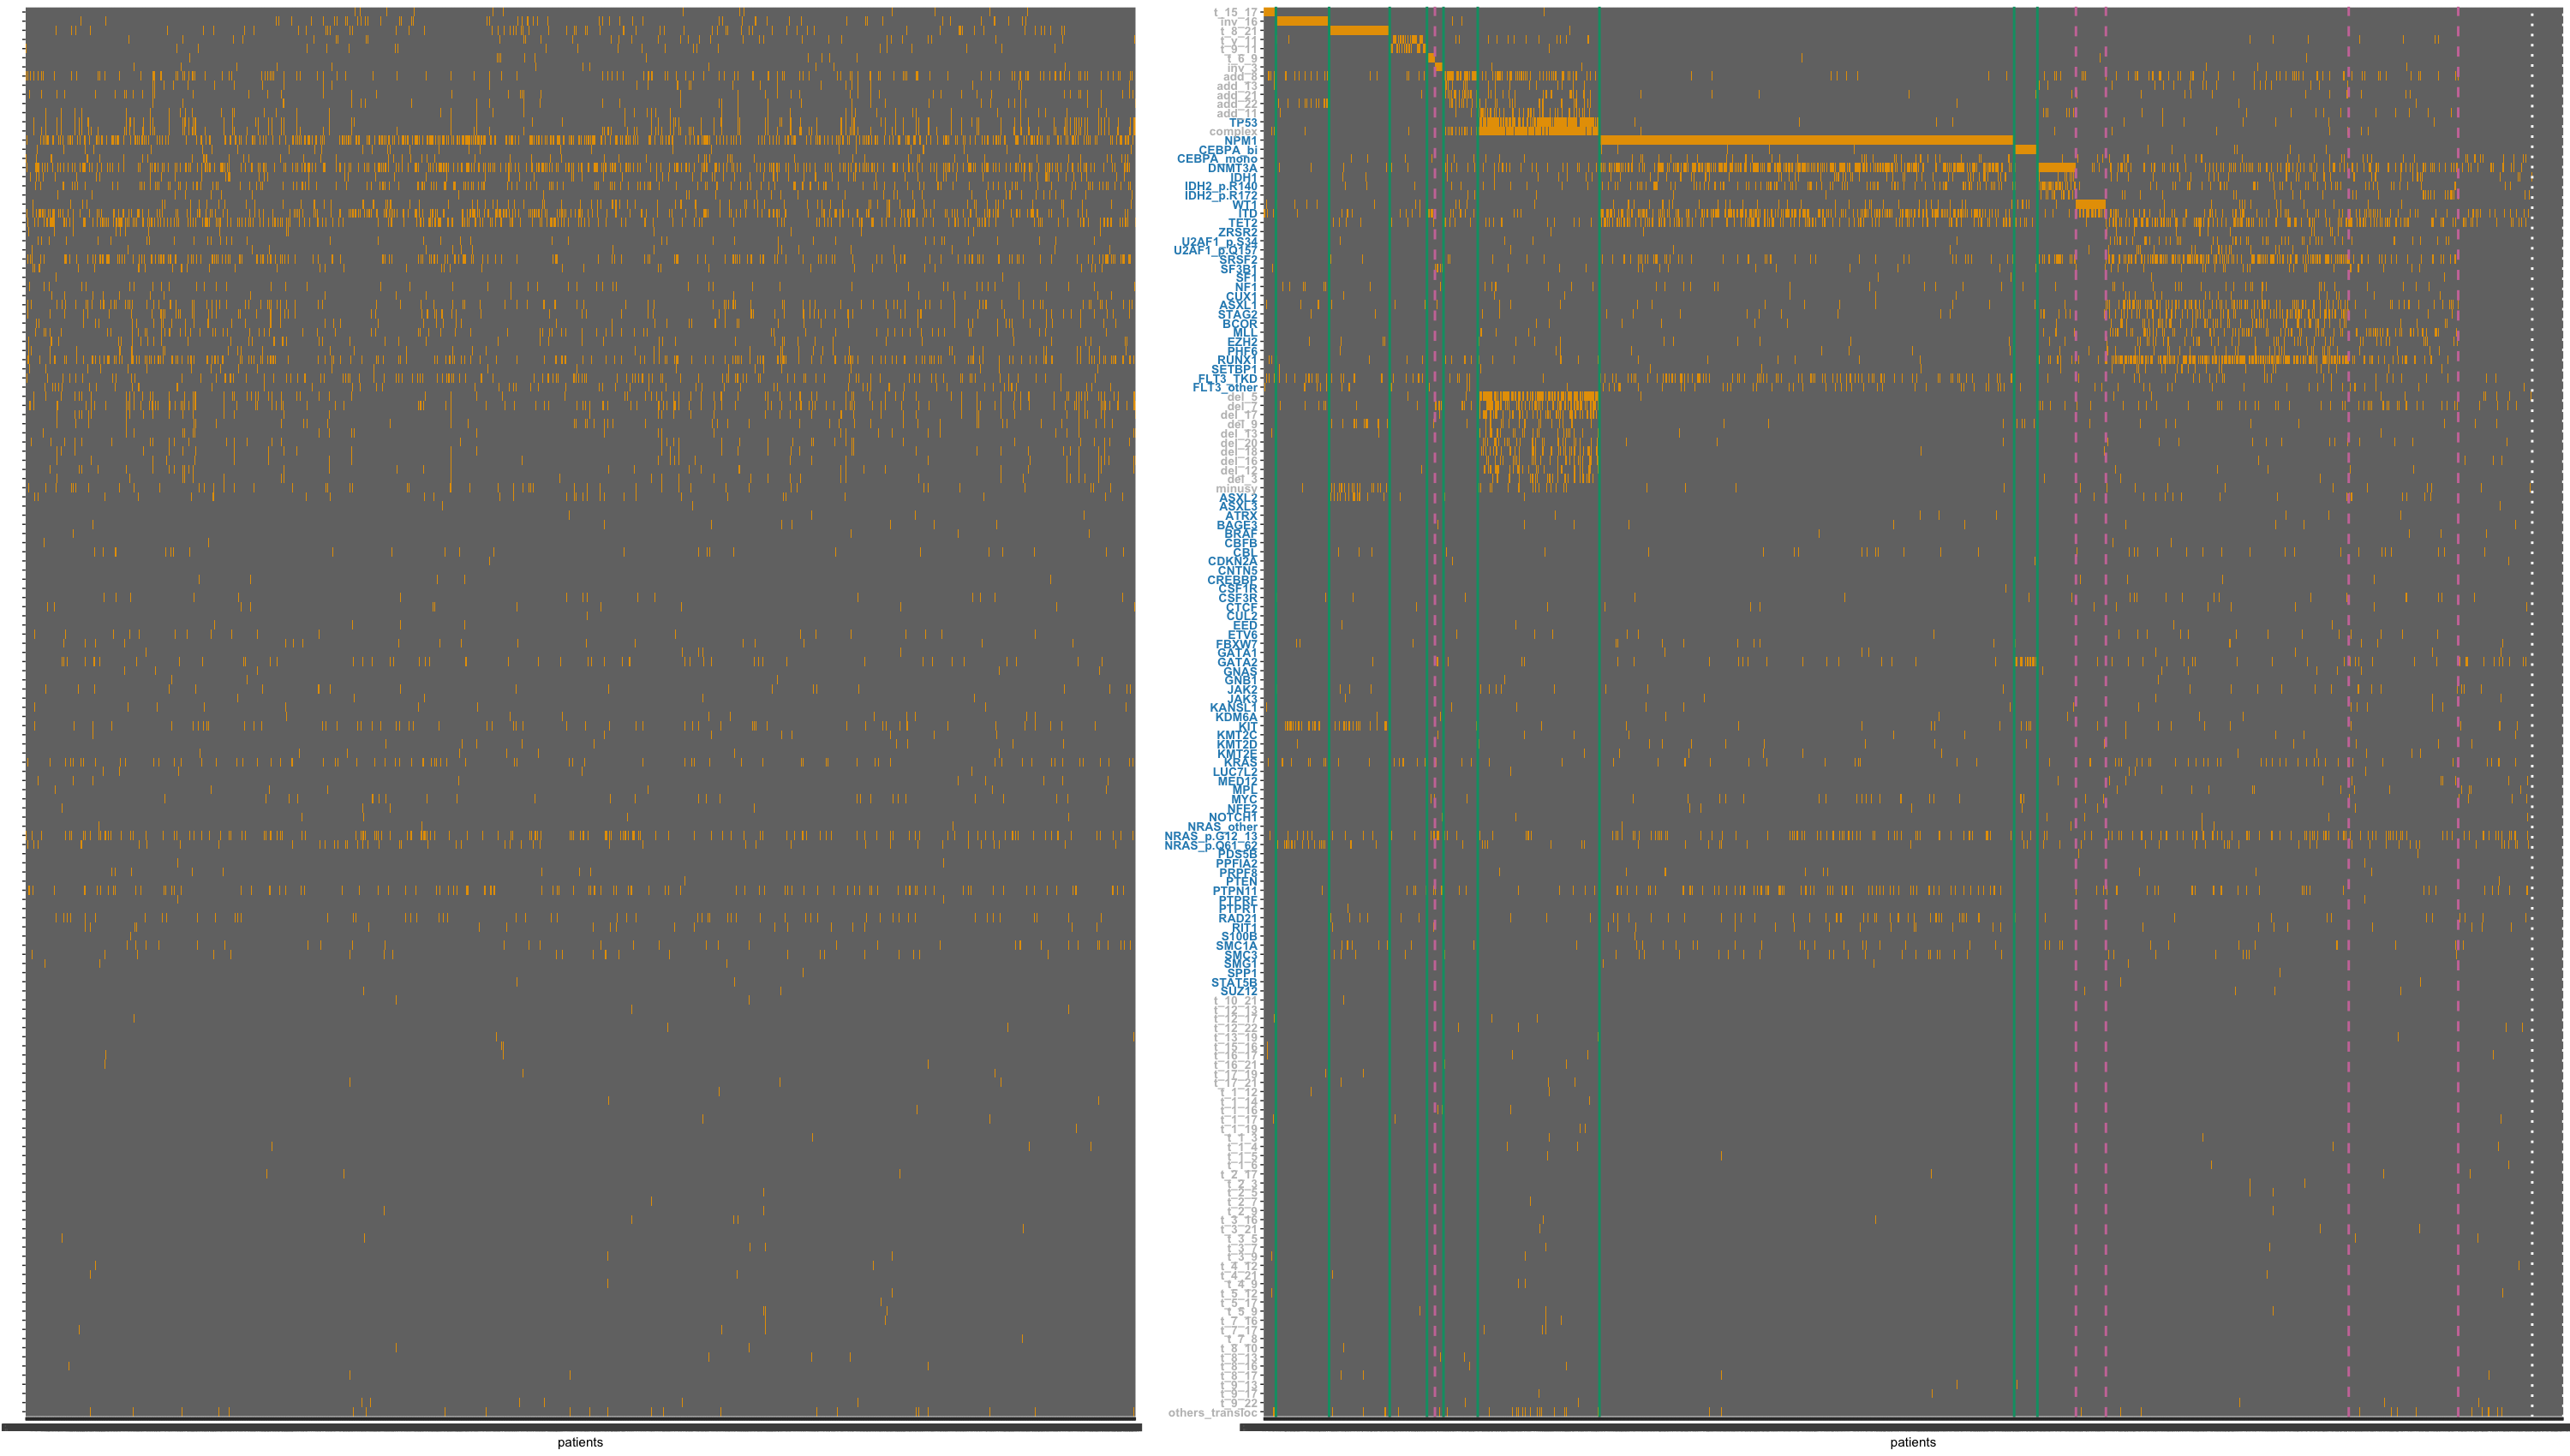

In [45]:
set_notebook_plot_size(30,17)
# png("figures/heatmaps.png",width=6000,height=4160,res=250)
p <- heatmaps(df_final, type=c("not_ordered"),cols_to_plot=c(genes,cytos))
q <- heatmaps(df_final, type=c("ordered"),cols_to_plot=c(genes,cytos))
grid.arrange(grobs=list(p,q),layout_matrix=rbind(c(1,1,1,1,2,2,2,2,2)))
# dev.off()

# IV.5) Components One by One Features frequency

Error : Faceting variables must have at least one value


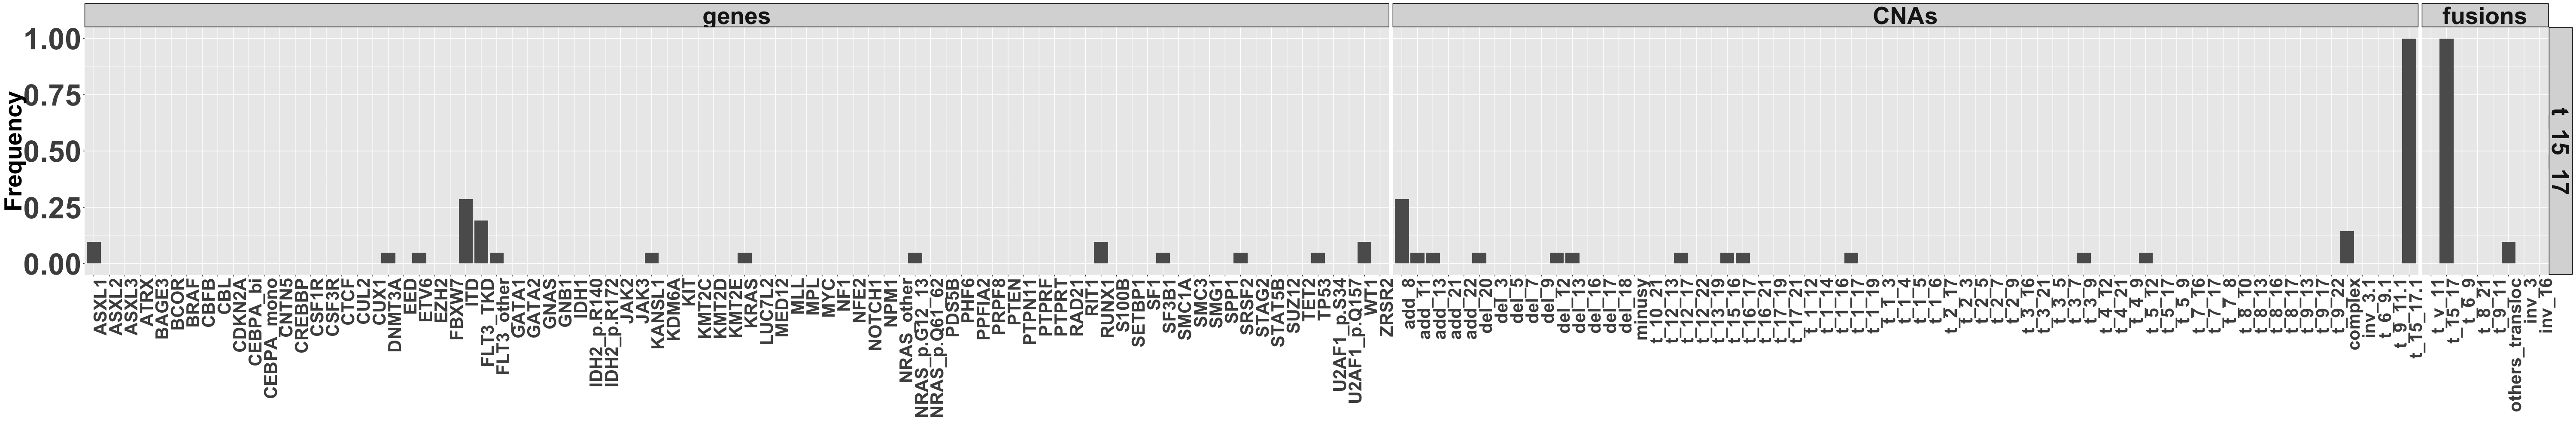

In [41]:
for (col in cols_component){
    png(paste("figures/",paste(col,"_frequency.png",sep=""),sep=""),width=4500,height=1000)
    try(plot(comp_features_frequency(df_final,genes,cytos,comp=col,cols_to_keep=c(genes,cytos,"inv_3","t_6_9","t_9_11","t_15_17"),facet_type=T,colors="#5C5C5C"))) ### try because of no events
    dev.off()
}
plot(comp_features_frequency(df_final,genes,cytos,comp=cols_component[1],cols_to_keep=c(genes,cytos,"inv_3","t_6_9","t_9_11","t_15_17"),facet_type=T,colors="#5C5C5C"))

# IV.6) Overall Components Features frequency 

In [43]:
# png("figures/overall_comp_freq.png",width=4500,height=5500)
plot(comp_features_frequency(df_final,genes,cytos,comp=cols_component,cols_to_keep=c(gen,cyto,"inv_3","t_6_9","t_9_11","t_15_17"),facet_type=T,colors=color_values))
# dev.off()

# IV.7) Components Overall number of alterations

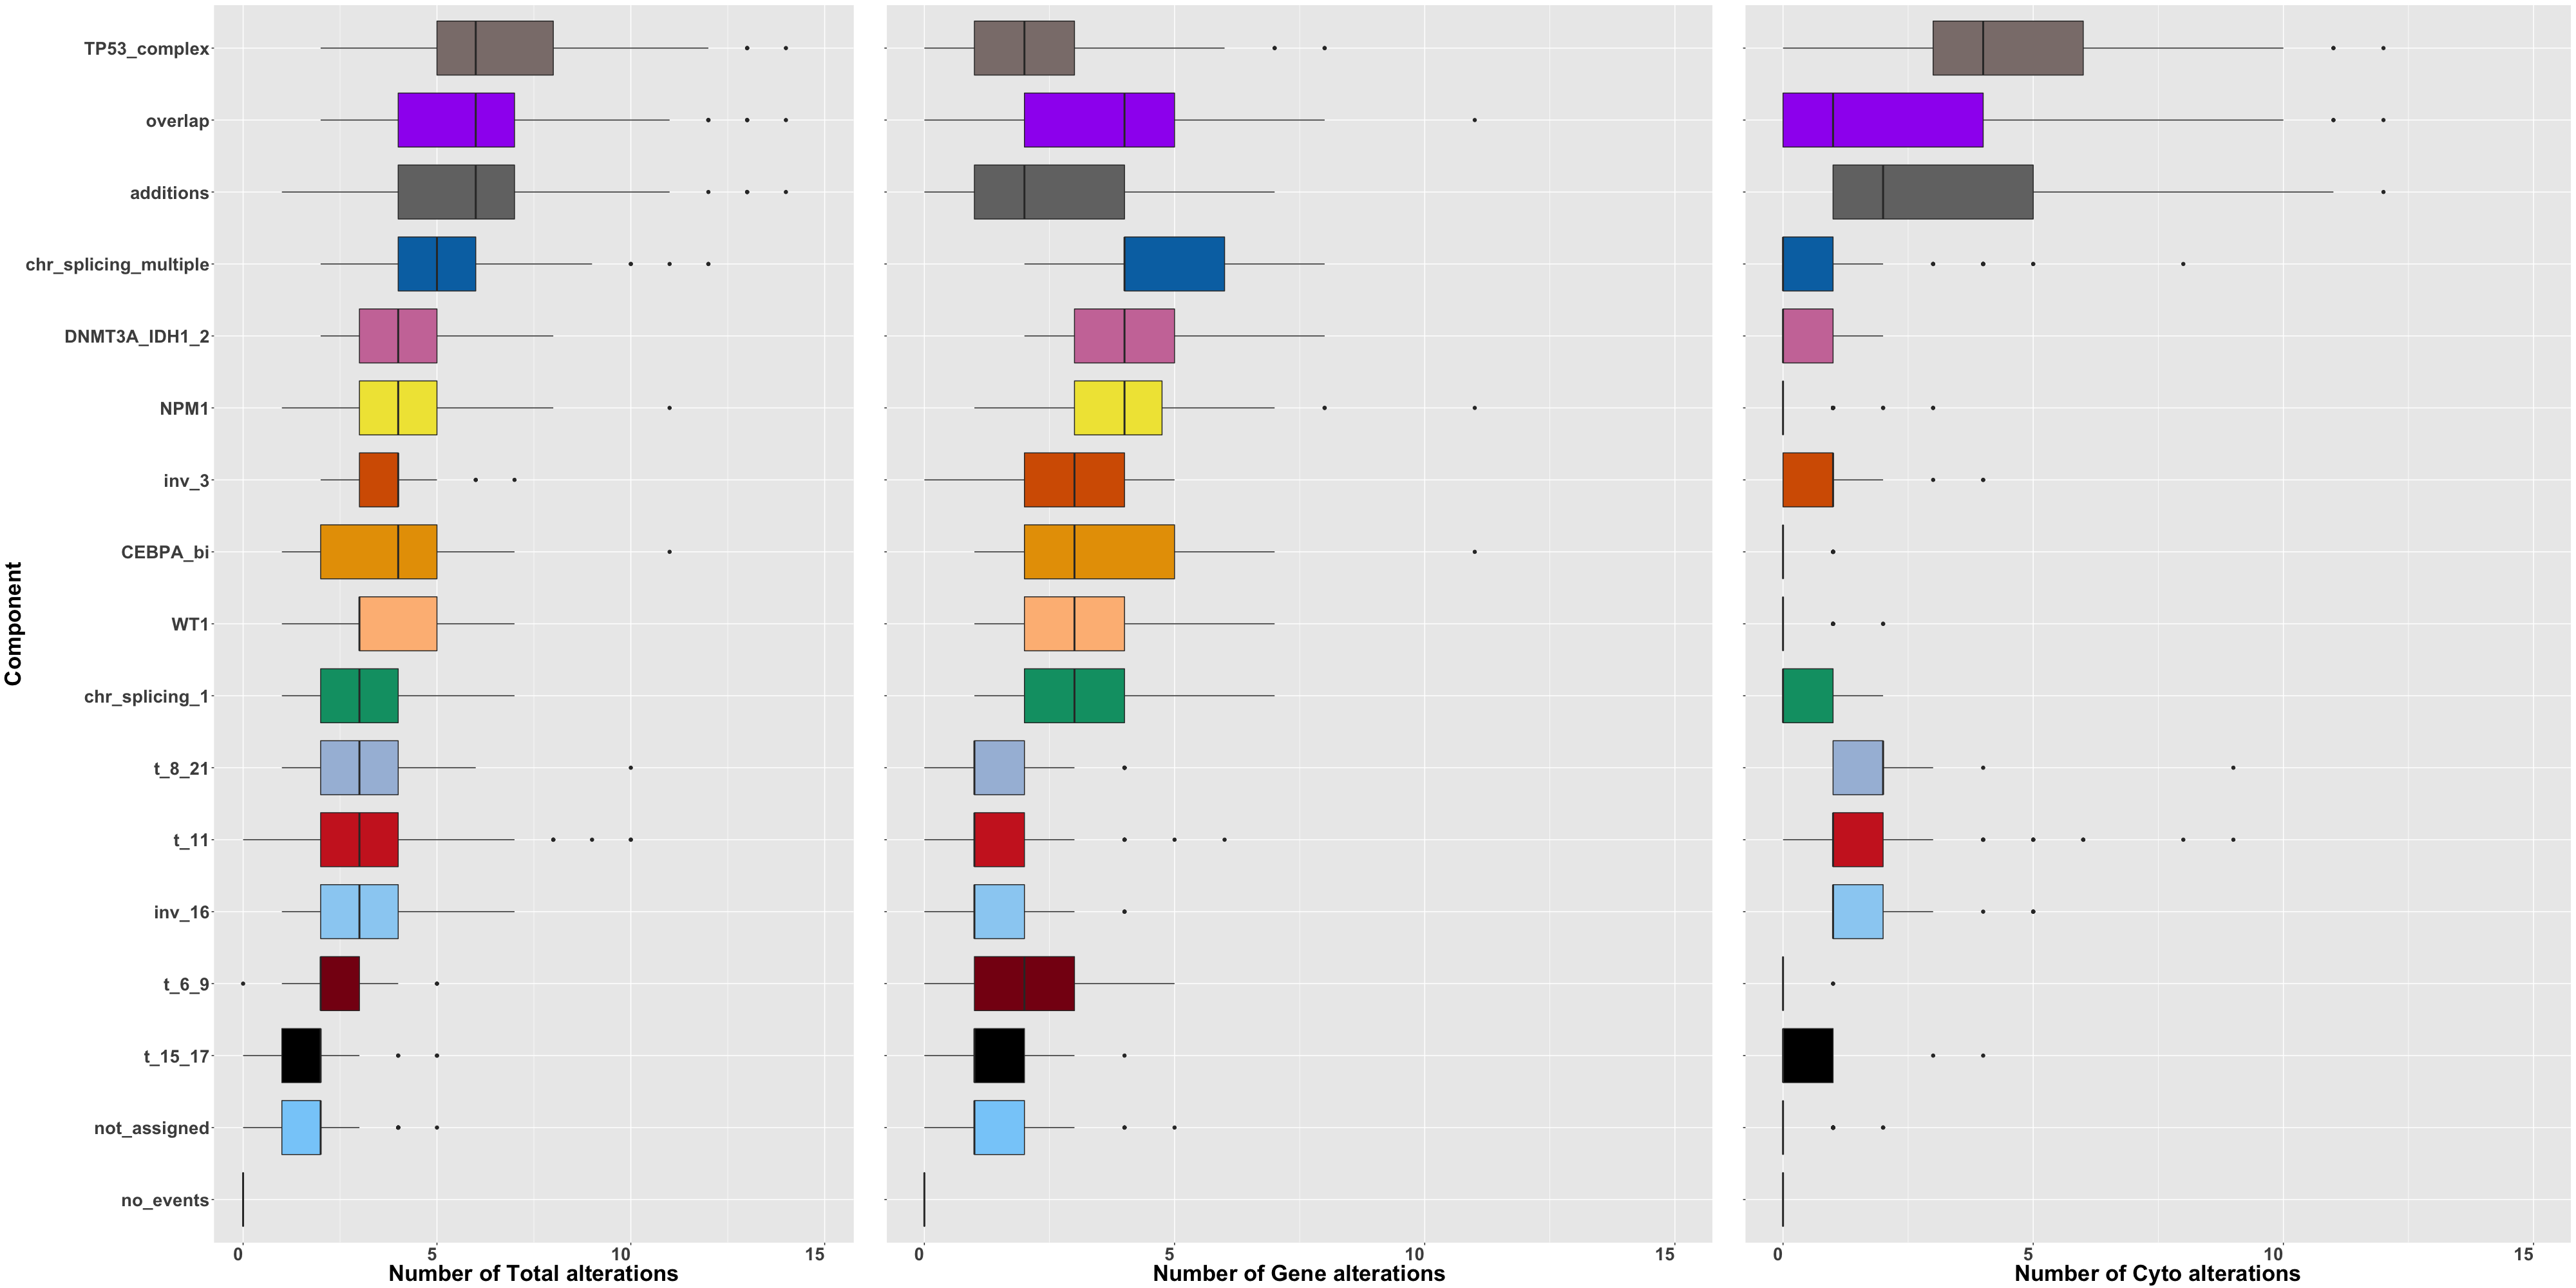

In [47]:
set_notebook_plot_size(40,20)
# png("figures/comp_overall_alt.png",width=4650,height=2500,res=200)
num_events_comp(df_final,cols_component=comp)
# dev.off()

# IV.8) 5 panel Overview

In [51]:
tmp <- NULL
for (co in c("full_component_TP53_complex","full_component_additions")){
    tmp1 <- df_w_correlates[df_w_correlates[,co]==1,]
    tmp1$comparison <- str_remove(co,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,submain="p53-aneuploidies",vals=c('grey45','#EE9937'),y="Survival Probability",legend=c(0.5,0.8))
    

# Panel 2

tmp <- NULL
for (co in c("t_9_11","t_v_11","inv_3","inv_16","t_6_9","t_8_21","t_15_17")){
    tmp1 <- df_w_correlates[df_w_correlates[,co]==1,]
    tmp1$comparison <- co
    tmp <- rbind(tmp,tmp1)
    }
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
q <- plot_surv_curves(fit,submain="fusions",vals=c('#9ad0f3','#D55E00','#000000','#870C14','#a6bddb','firebrick3','firebrick3'),legend=c(0.75,0.51))

                                                                                                    
# Panel 3
tmp <- NULL
for (co in c("NPM1","CEBPA_bi")){
    tmp1 <- df_w_correlates[df_w_correlates[,co]==1,]
    tmp1$comparison <- co
    tmp <- rbind(tmp,tmp1)
    }
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
r <- plot_surv_curves(fit,submain="known gene groups",vals=c('#e79f00','#F0E442'),legend=c(0.5,0.8))
               
# Panel 4
tmp <- NULL
for (co in c("full_component_WT1","full_component_DNMT3A_IDH1_2","full_component_chr_splicing_1","full_component_chr_splicing_multiple")){
    tmp1 <- df_w_correlates[df_w_correlates[,co]==1,]
    tmp1$comparison <- str_remove(co,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
s <- plot_surv_curves(fit,vals=c('grey45','#009E73','#0072B2','#CC79A7','#fdbb84'),submain="new gene groups",legend=c(0.58,0.8))

#Panel 5
tmp <- NULL
for (co in c("full_component_not_assigned","full_component_no_events")){
    tmp1 <- df_w_correlates[df_w_correlates[,co]==1,]
    tmp1$comparison <- str_remove(co,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }

surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)               
t <- plot_surv_curves(fit,submain="no classification",legend=c(0.5,0.8))             
set_notebook_plot_size(50,15)  


png("figures/panelLEGEND.png",width=10000,height=2500,res=210)
grid.arrange(p$plot,q$plot,r$plot,s$plot,t$plot,ncol=5)
dev.off()

pdf 
  2

# IV.9) Components Spread Survival

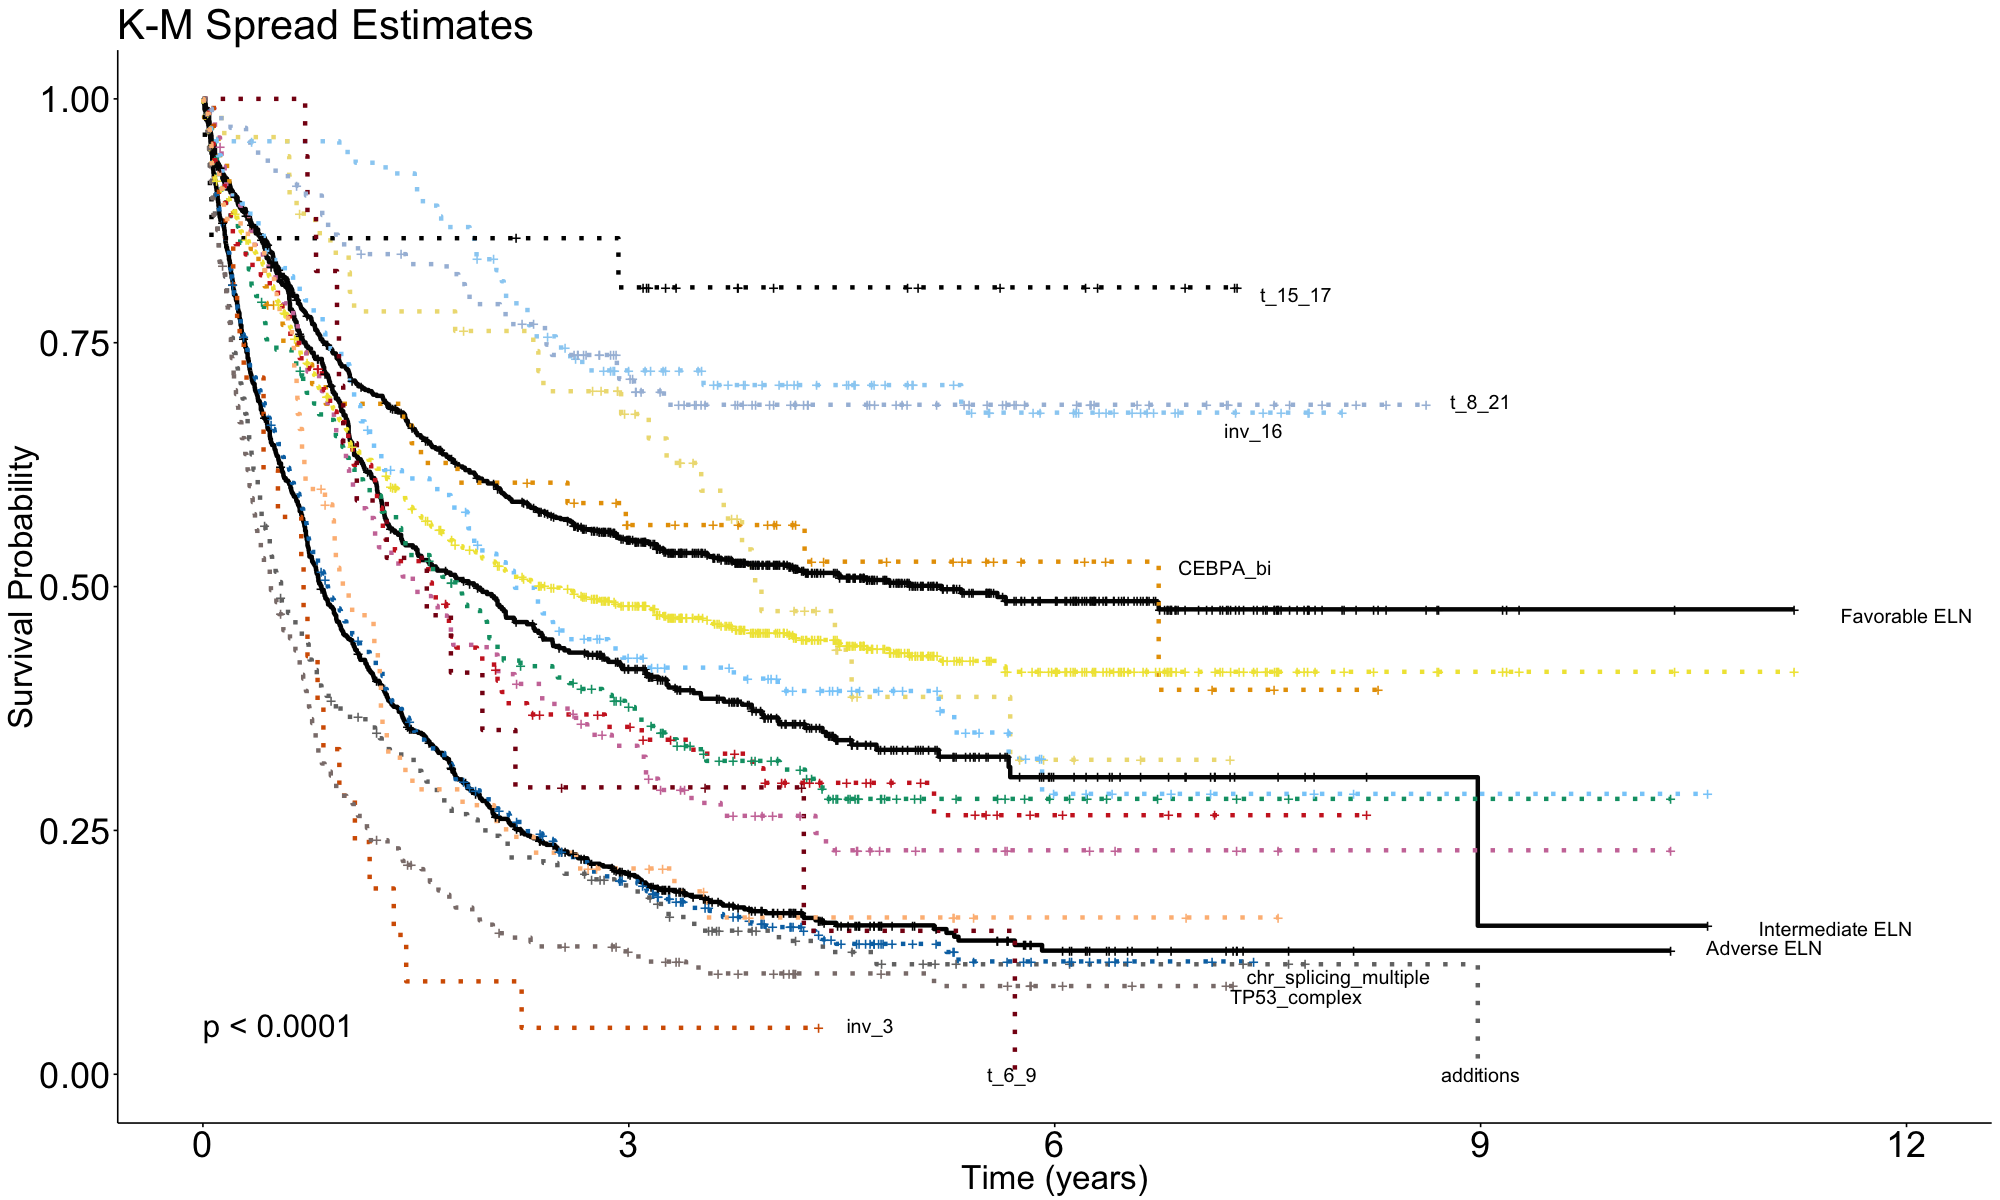

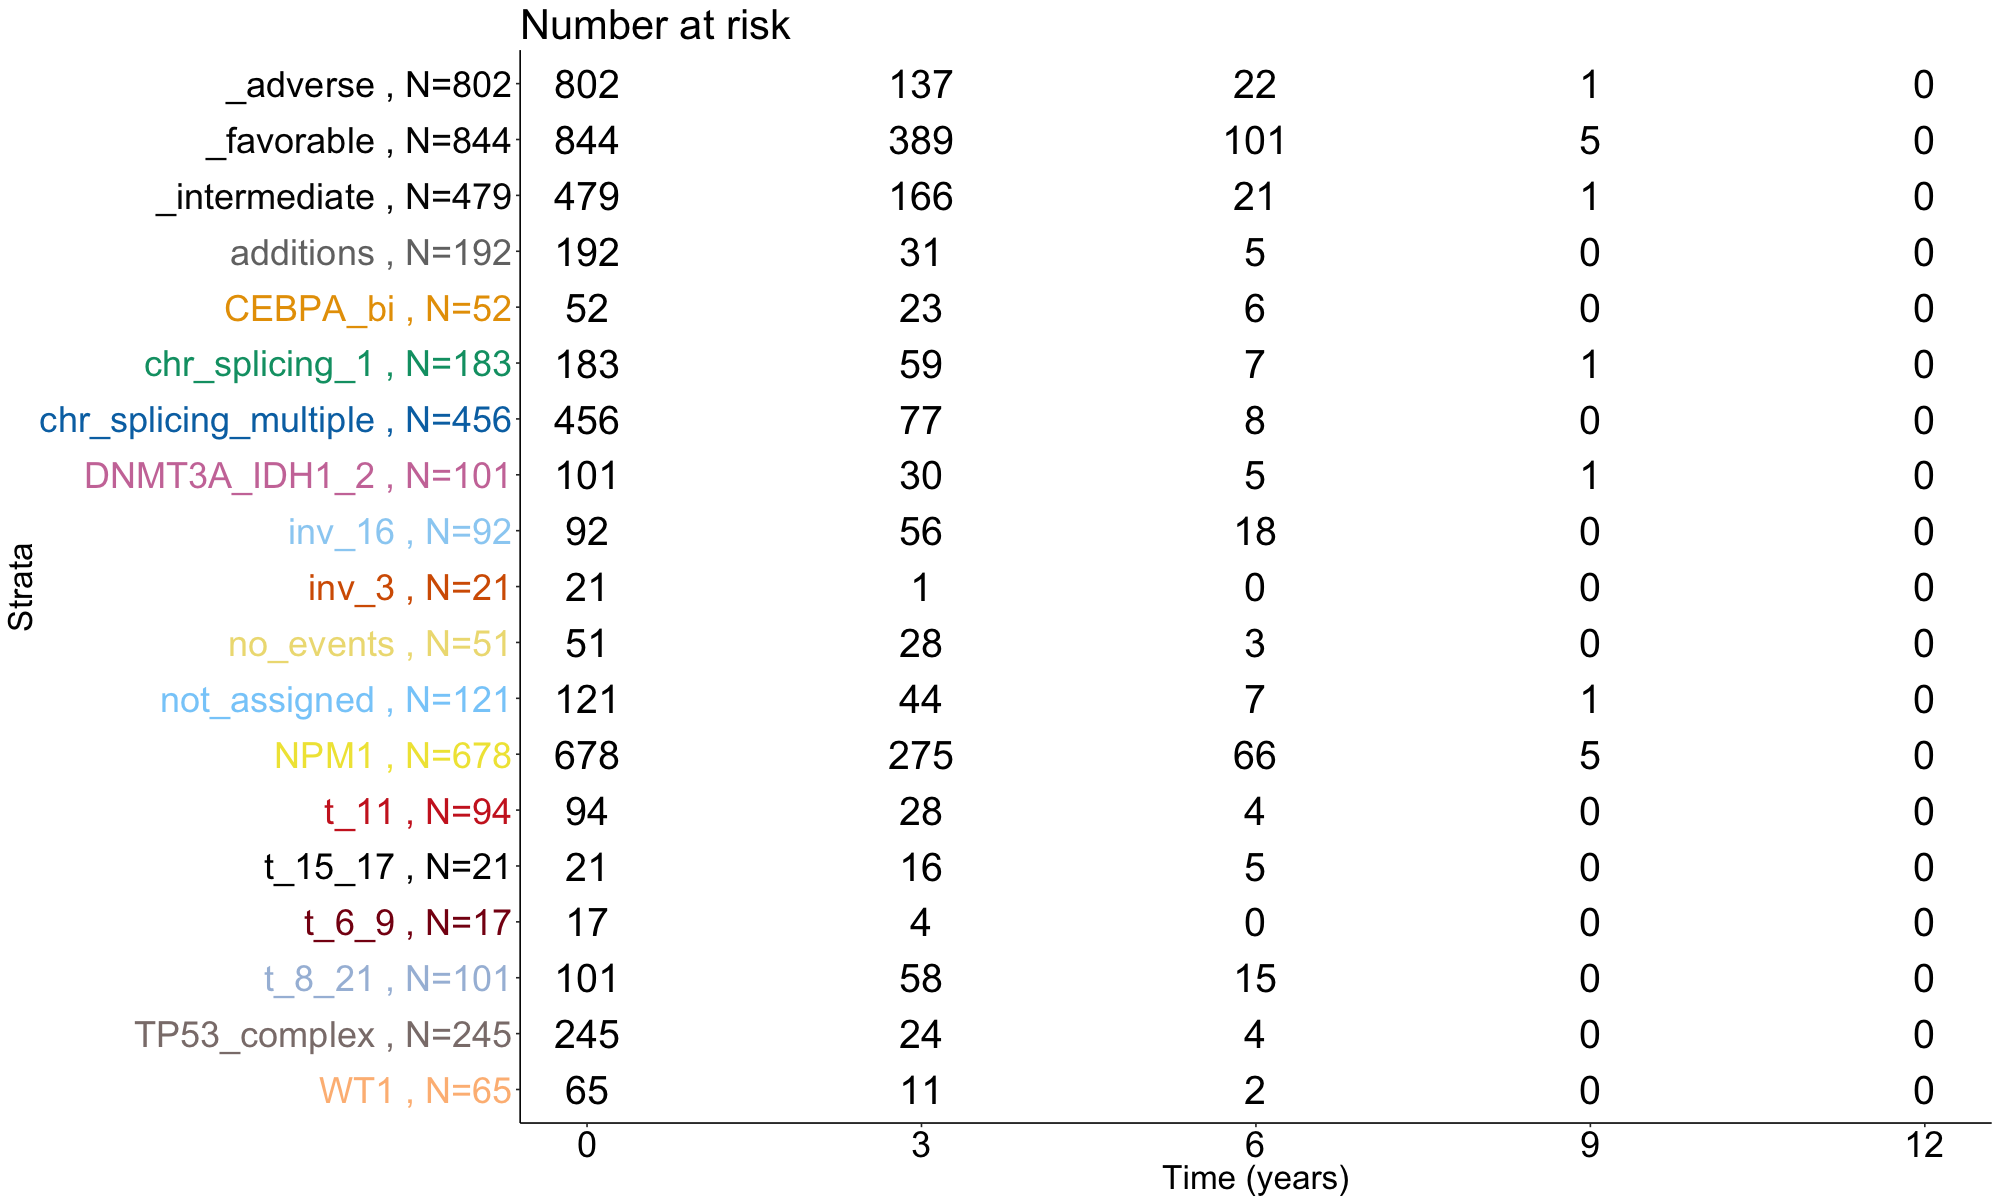

In [53]:
source('tools.R')
colors <- c("black","gray1","gray2",as.vector(unlist(color_values)))

tmp <- NULL
for (col in cols_component){
    tmp1 <- df_w_correlates[df_w_correlates[,col]==1,]
    tmp1$comparison <- str_remove(col,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }

tmp1 <- df_final

tmp1$comparison <- ifelse(tmp1$eln_2017==1,"_adverse",
                          ifelse(tmp1$eln_2017==2,"_intermediate","_favorable"))
                          
tmp <- rbind(tmp,tmp1)
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,submain = "K-M Spread Estimates",vals=colors,linetype=c(1,1,1,rep(3,16)),size=1.5,y="Survival Probability",legend="none",risk.tab=T)


set_notebook_plot_size(20,12)
# png("figures/spread_surv_plot.png",width=5500,height=4500,res=350)
p$plot + ggplot2::annotate("text", 
                                x = c(4.7,5.7,7.7,9,8,11,11.5,12,7.2,7.4,9,7.7), y = c(0.05,0,0.08,0,0.1,0.13,0.15,0.47,0.52,0.66,0.69,0.8),
                                label = c("inv_3","t_6_9","TP53_complex","additions","chr_splicing_multiple","Adverse ELN","Intermediate ELN",
                                          "Favorable ELN","CEBPA_bi","inv_16","t_8_21","t_15_17"), size = 5)
# dev.off()
# png("figures/spread_surv_table.png",width=5000,height=5000,res=350)
p$table
# dev.off()


# IV.10) Components Clinical Correlates

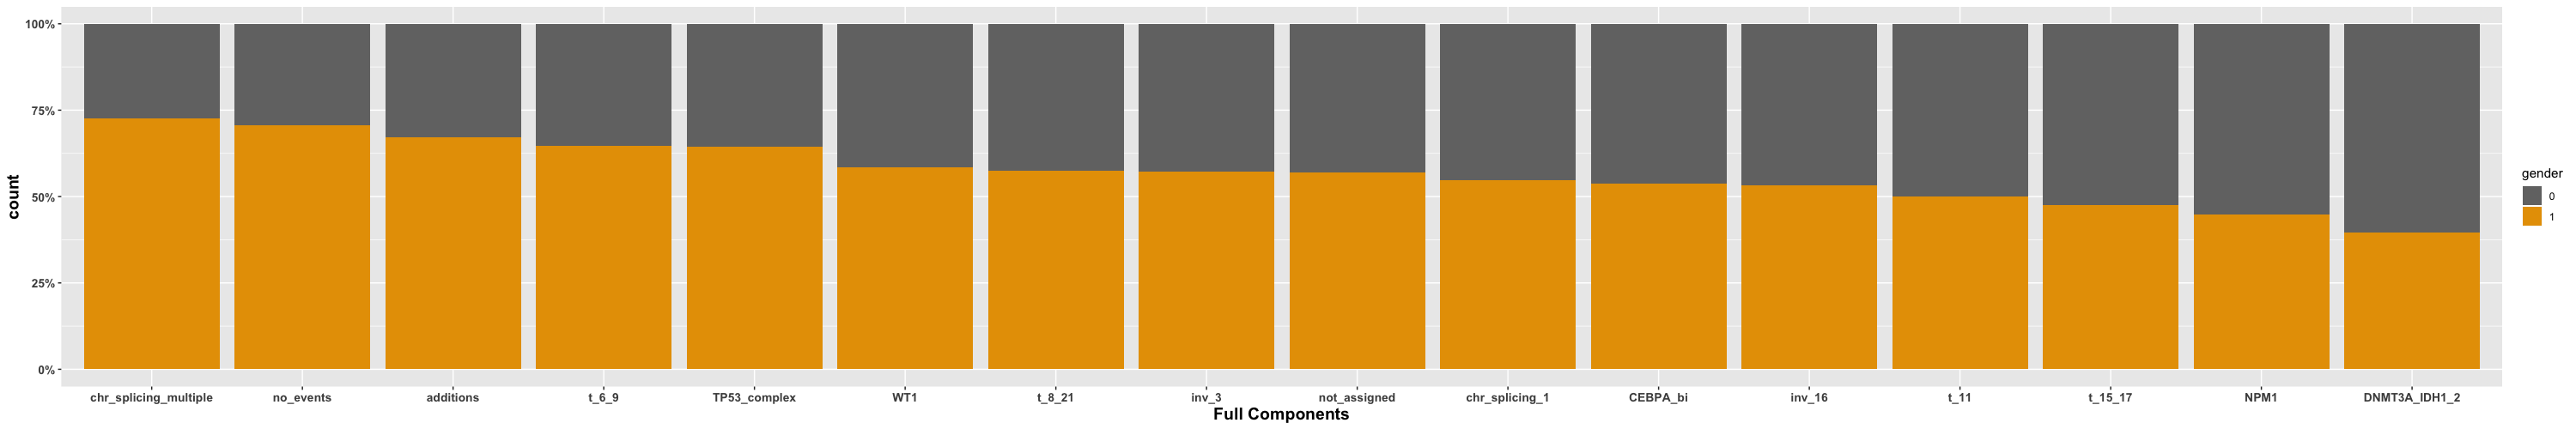

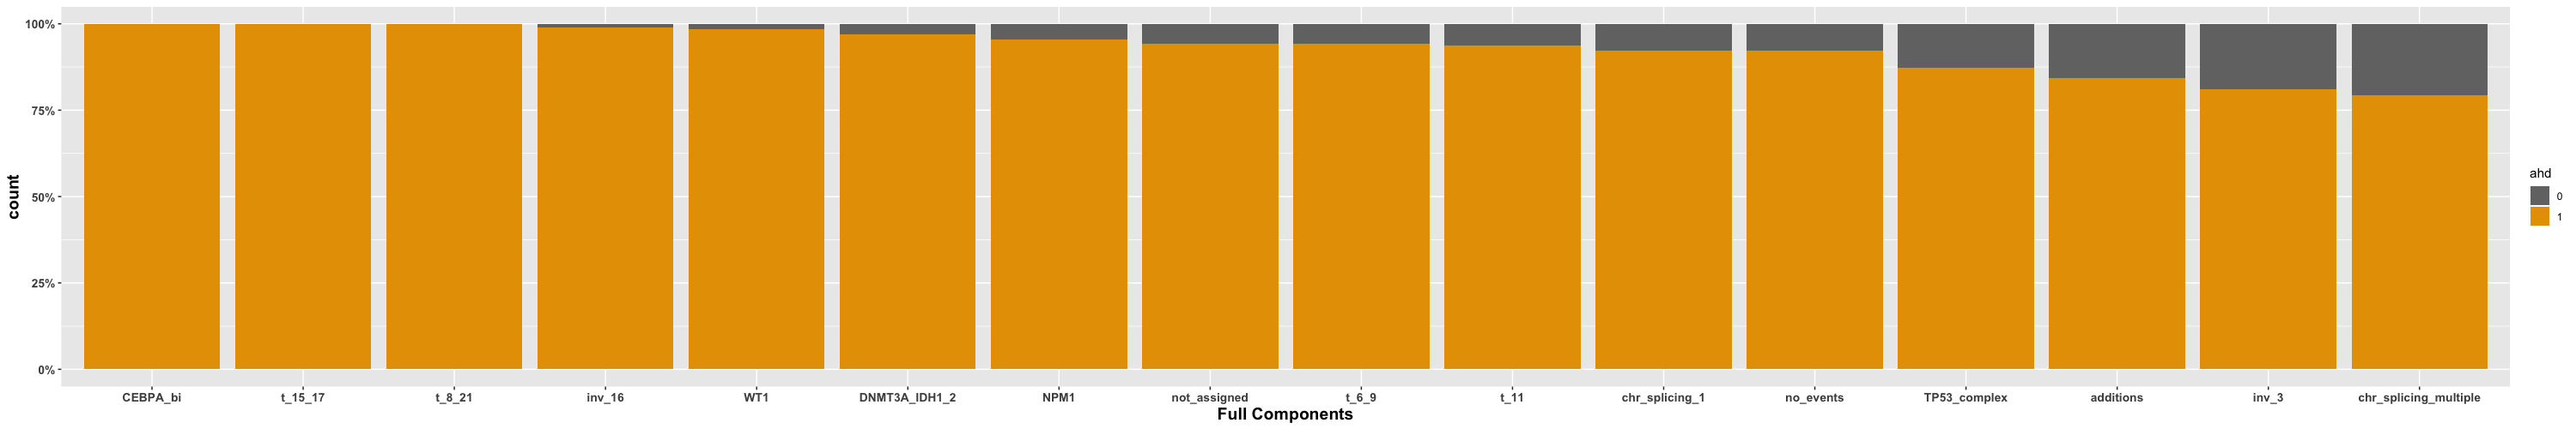

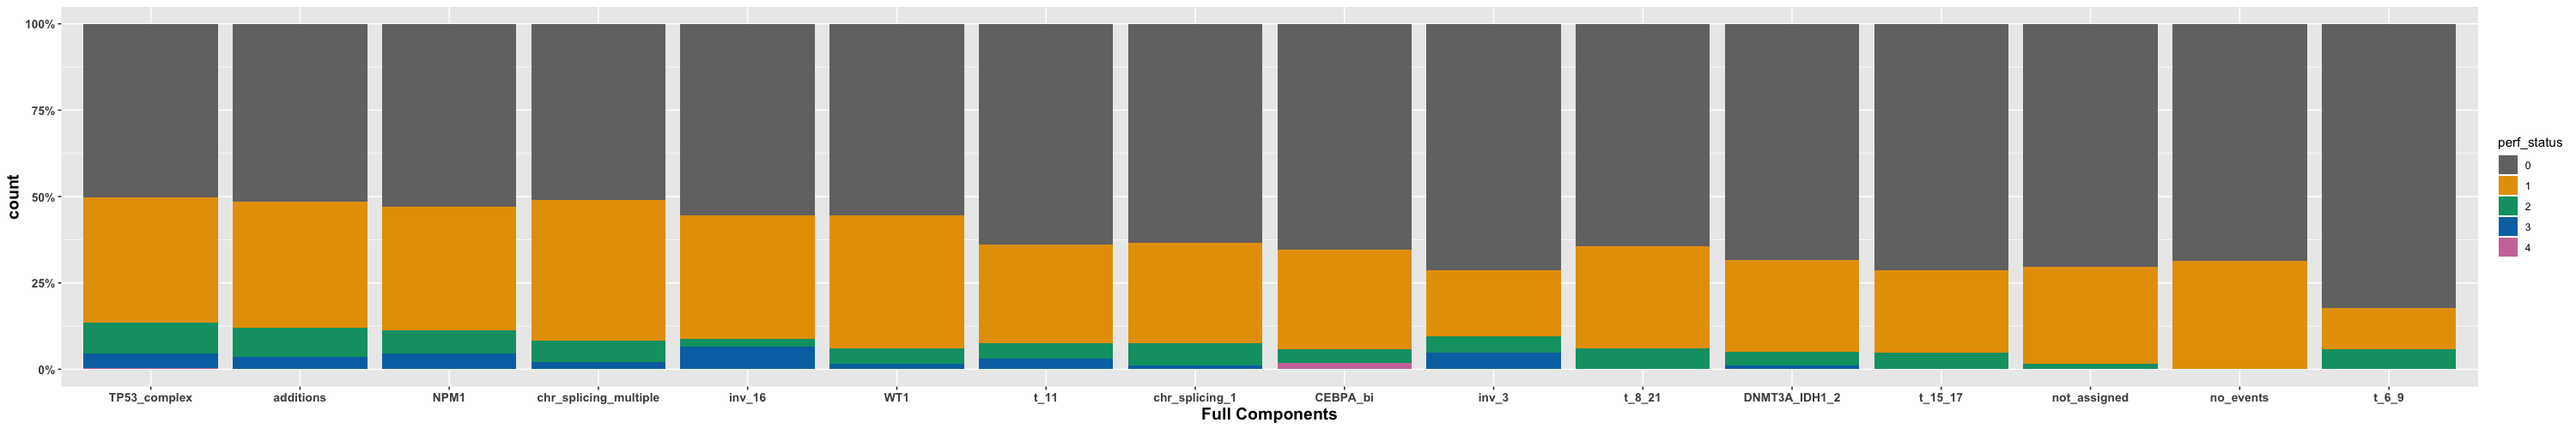

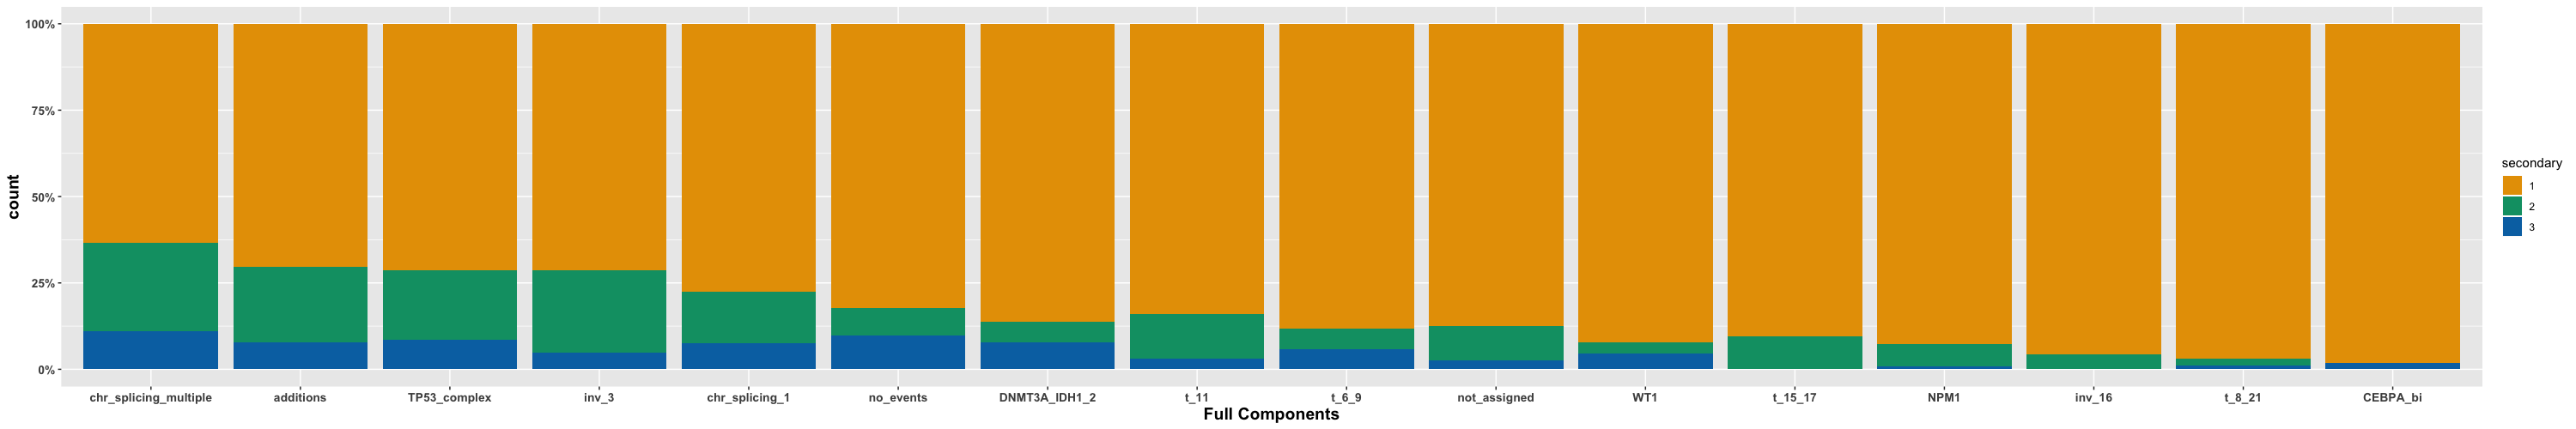

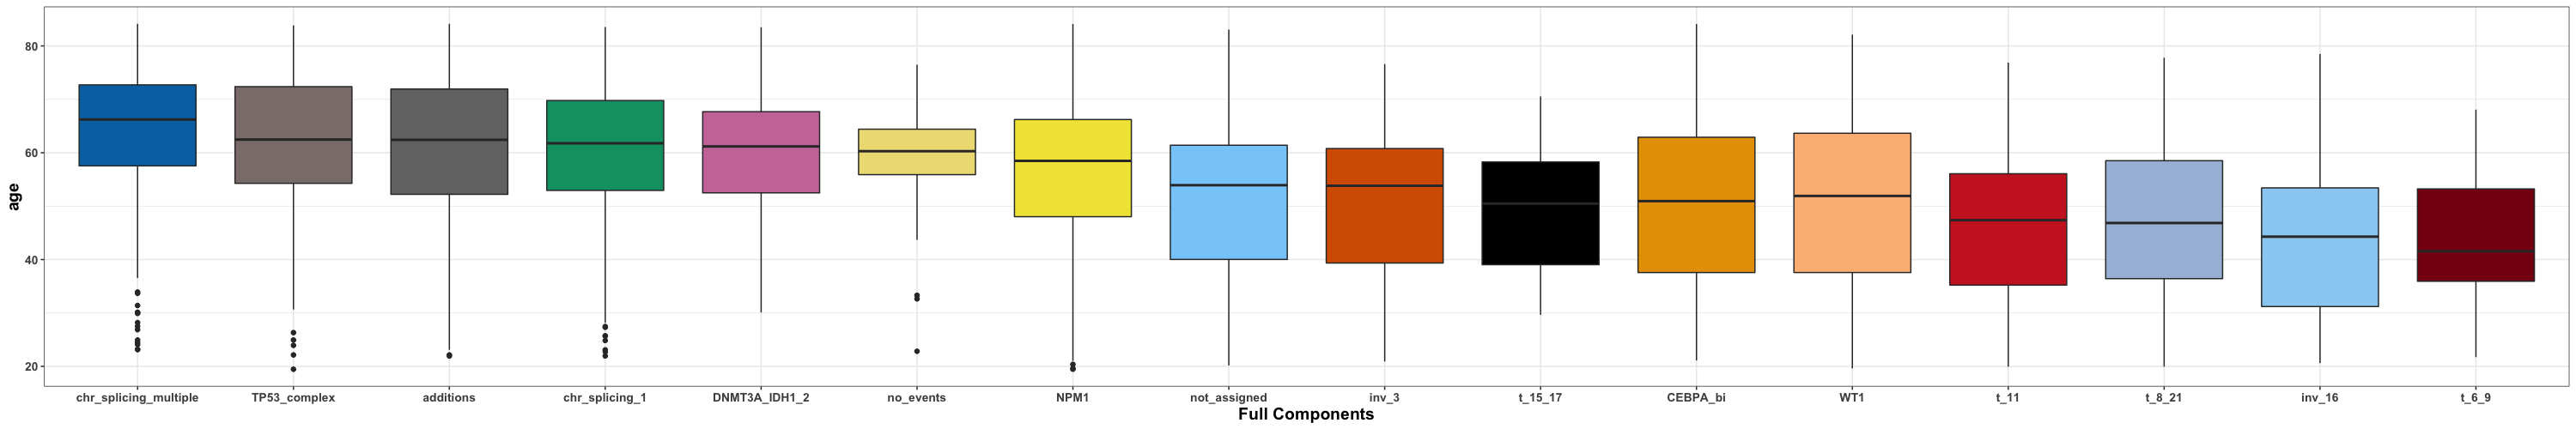

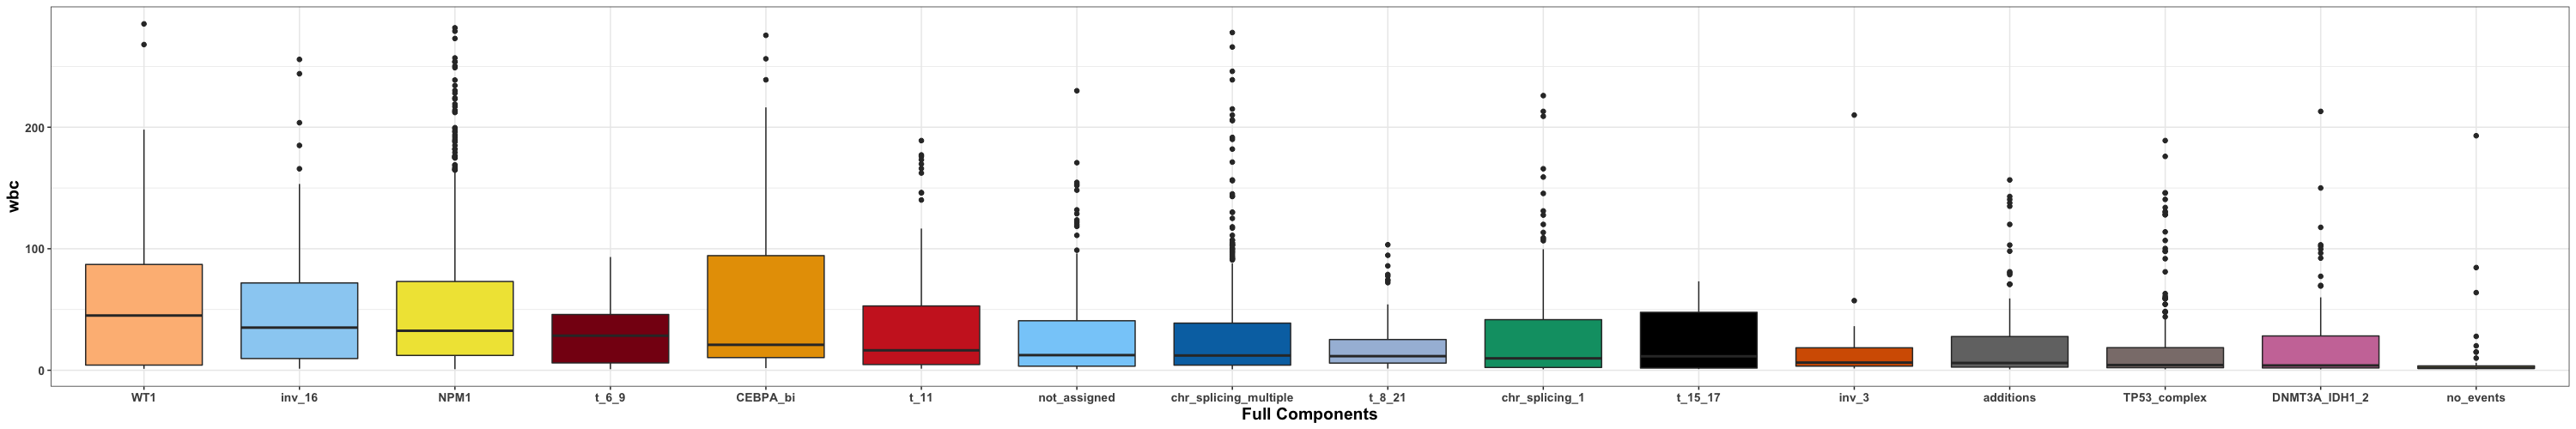

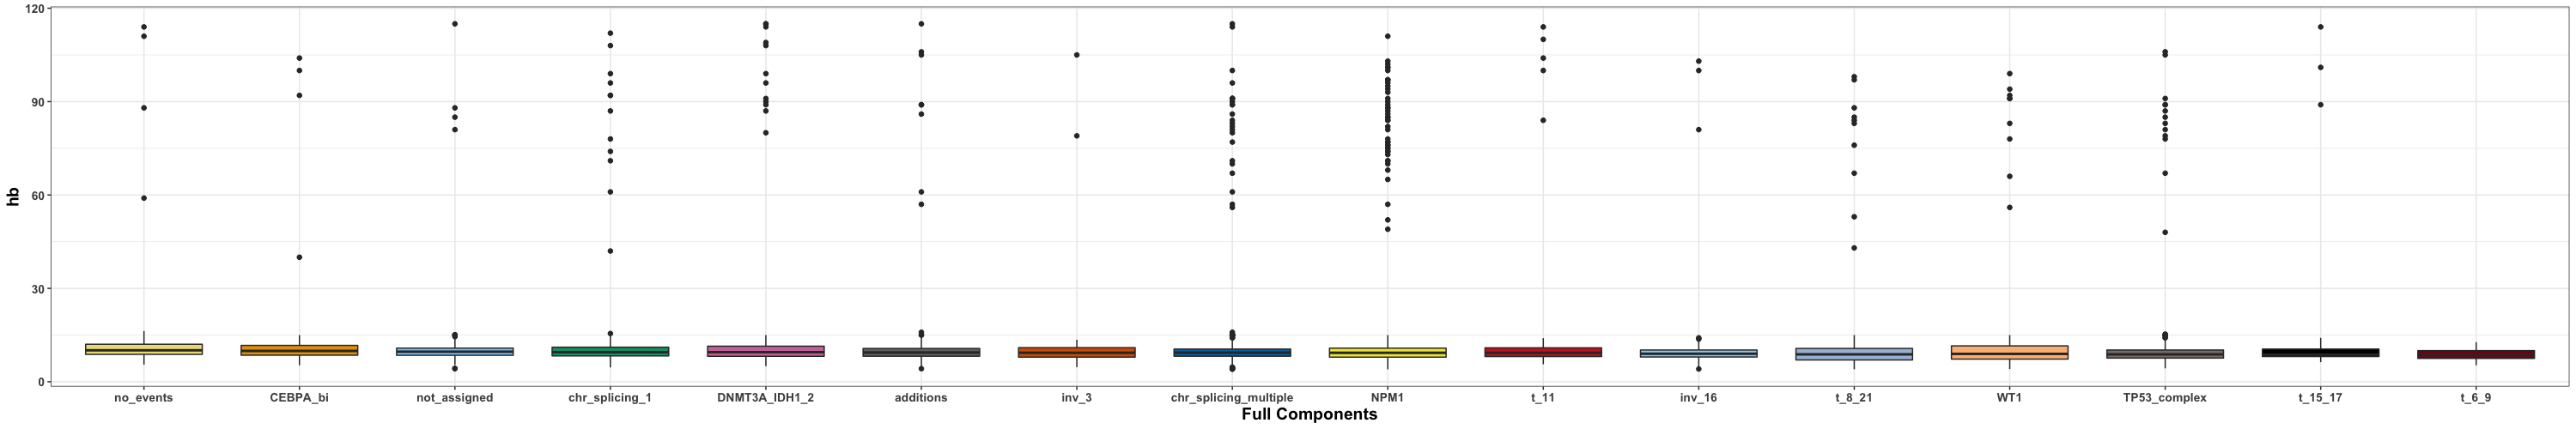

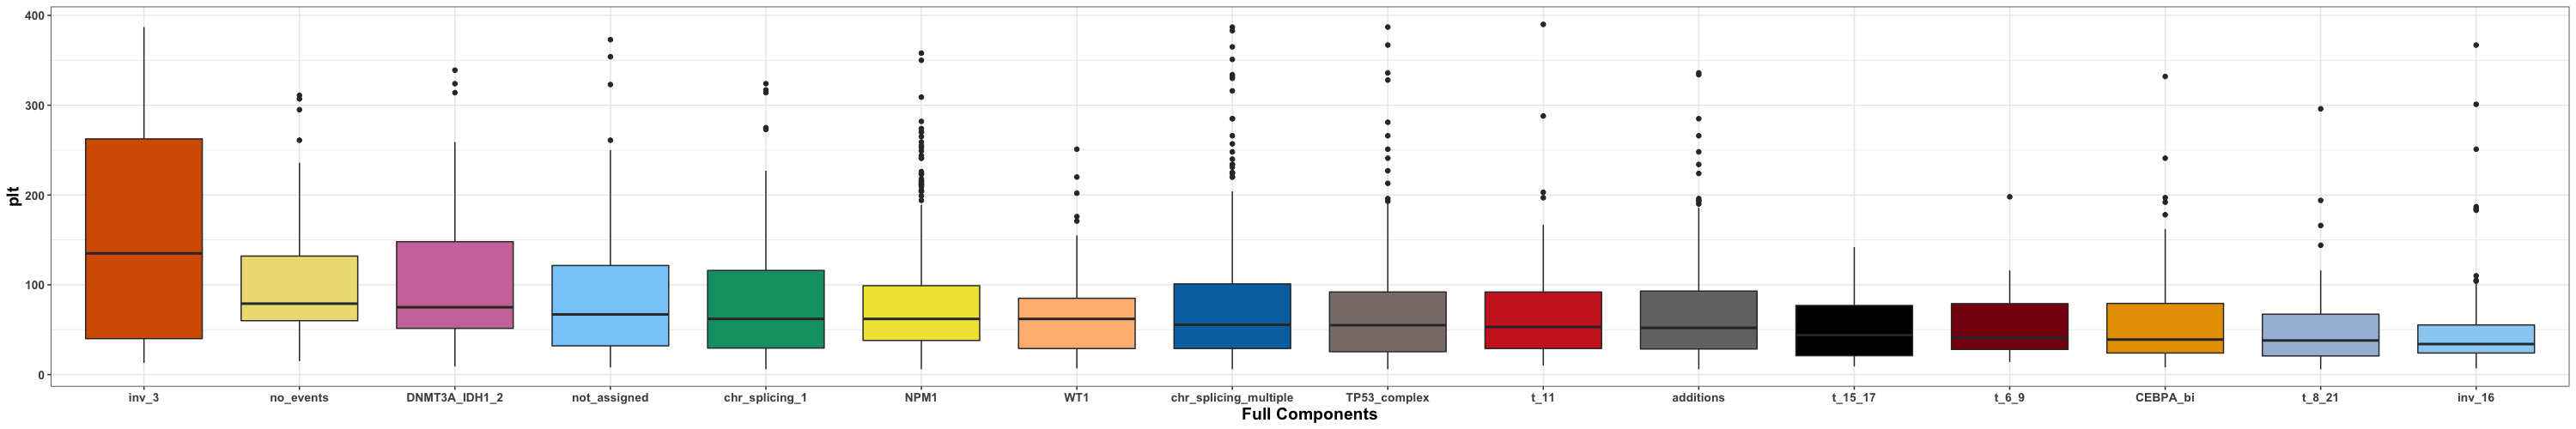

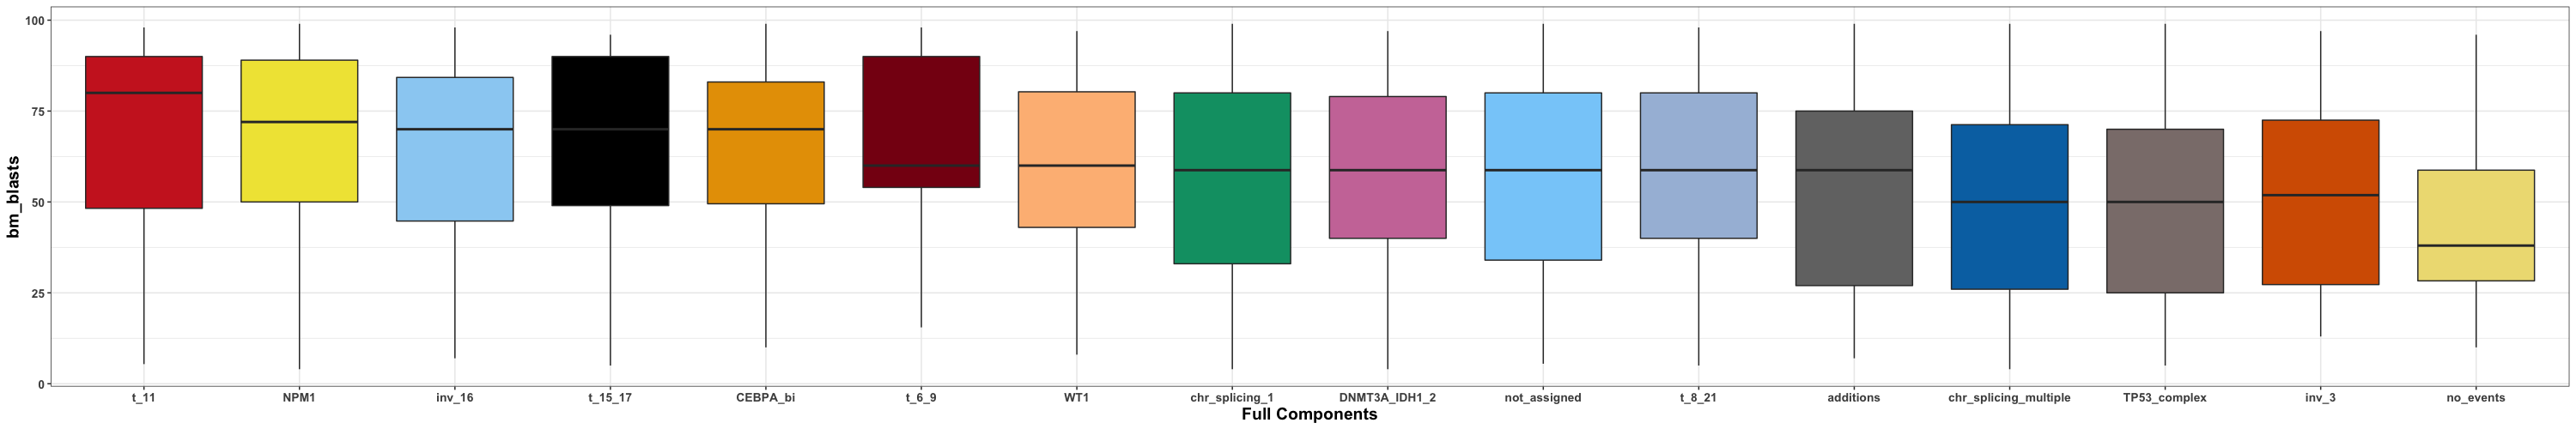

In [63]:
        ### Plot with all
comp_clinical_correlates(df_w_correlates,cols_component=cols_component,binary_correlates = c("gender","ahd","perf_status","secondary"),continuous_correlates=c("age","wbc","hb","plt","bm_blasts"))

        ### one by one 

for (bin in c("gender","ahd","perf_status","secondary")){
    png(paste("figures/","_clinical.png",sep=bin),width=4800,height=1500,res=240)
    comp_clinical_correlates(df_w_correlates,cols_component=cols_component,binary_correlates = bin,continuous_correlates=NULL)
    dev.off()
}
        
for (cont in c("age","wbc","hb","plt","bm_blasts")){
    png(paste("figures/","_clinical.png",sep=cont),width=4800,height=2500,res=240)
    comp_clinical_correlates(df_w_correlates,cols_component=cols_component,binary_correlates = NULL,continuous_correlates=cont)
    dev.off()        
}

# V) Components digging

# V.1) TP53-Complex

In [305]:
binary_correlates <- c("gender","ahd","perf_status","secondary")
continuous_correlates <- c("age","wbc","hb","plt","bm_blasts")
v=c("0" = "grey45", "1" = "#e79f00", "2" = "#009E73", "3" ="#0072B2", "4"="#CC79A7")

tmp <- df_final[df_final$full_component_TP53_complex==1,]

tmp$comparison <- ifelse(tmp$TP53==1 & tmp$complex==1,"TP53-complex",
                        ifelse(tmp$TP53==1,"TP53","complex"))
tmp$comparison <- factor(tmp$comparison)


# Surv
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)

png("figures/digging_comp_tp53_complex_surv.png",width=5000,height=5000,res=300)
plot_surv_curves(fit,legend="top",submain="TP53-complex Component",risk.tab=F,y="Survival Probability",vals = c("#5C5C5C","#EE9937","darkgreen"))
dev.off()



# Correlates
p <- list()
q <- list()

for (bin in binary_correlates){
    p[[bin]] <- ggplot(tmp, aes_string(x="comparison",fill=factor(tmp[,bin])))+geom_bar(position = "fill")+
      scale_y_continuous(labels = scales::percent)+xlab(ifelse(i==4,"Comparison",""))+ylab("")+scale_fill_manual(values = v)+
         theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=20,face="bold"),
            axis.title=element_text(size=14,face="bold"),legend.title = element_text(size=25),legend.text = element_text(size=20))+
        guides(fill=guide_legend(title=bin))
}
for (cont in continuous_correlates){
    q[[cont]] <- ggplot(tmp,aes_string(x="comparison",y=tmp[,cont])) +
    geom_boxplot(aes(fill = factor(comparison))) + stat_compare_means(comparisons=list(c("TP53-complex","TP53"),c("TP53-complex","complex"),c("TP53","complex")),paired=F,test="wilcox.test",size=5)+
    scale_fill_manual(values=c("#5C5C5C","#EE9937","darkgreen"))+ylab(cont)+xlab("")+
    theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=30,face="bold"),axis.title=element_text(size=34,face="bold"))+theme(legend.position = "none")#+
    #scale_y_continuous(limits = quantile(tmp[,cont], c(0.1, 0.9),na.rm=T))
}

png("figures/digging_comp_tp53_complex_bin_correlates.png",width=4000,height=5000,res=250)
do.call("grid.arrange",c(p,nrow=length(p)))
dev.off()

png("figures/digging_comp_tp53_complex_cont_correlates.png",width=4800,height=5200,res=220)
do.call("grid.arrange",c(q,nrow=length(q)))
dev.off()

pdf 
  2

pdf 
  2

pdf 
  2

# V.2) IDH 1-2 

In [306]:
binary_correlates <- c("gender","ahd","perf_status","secondary")
continuous_correlates <- c("age","wbc","hb","plt","bm_blasts")
v=c("0" = "grey45", "1" = "#e79f00", "2" = "#009E73", "3" ="#0072B2", "4"="#CC79A7")

tmp <- df_w_correlates[df_w_correlates$full_component_DNMT3A_IDH1_2==1,]

tmp$comparison <- ifelse(tmp$IDH1==1,"IDH1",
                        ifelse(tmp$IDH2_p.R140==1,"IDH2_p.R140","IDH2_p.R172"))
tmp$comparison <- factor(tmp$comparison)

# Surv IDH 
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)

png("figures/digging_comp_dnmt3a_idh_surv.png",width=5000,height=5000,res=300)
plot_surv_curves(fit,legend="top",submain="IDH Separation in component DNMT3A IDH",risk.tab=F,y="Survival Probability",vals = c("#5C5C5C","#EE9937","darkgreen"))
dev.off()

# Surv IDH2 STRAT 
surv_object <- Surv(time = tmp[tmp$comparison=="IDH2_p.R140" | tmp$comparison=="IDH2_p.R172",]$os, event = tmp[tmp$comparison=="IDH2_p.R140" | tmp$comparison=="IDH2_p.R172",]$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp[tmp$comparison=="IDH2_p.R140" | tmp$comparison=="IDH2_p.R172",])

png("figures/digging_comp_dnmt3a_idh2_surv.png",width=5000,height=5000,res=300)
plot_surv_curves(fit,legend="top",submain="IDH2 Separation in component DNMT3A IDH",risk.tab=F,y="Survival Probability",vals = c("#EE9937","darkgreen"))
dev.off()

# Correlates
p <- list()
q <- list()

for (bin in binary_correlates){
    p[[bin]] <- ggplot(tmp, aes_string(x="comparison",fill=factor(tmp[,bin])))+geom_bar(position = "fill")+
      scale_y_continuous(labels = scales::percent)+xlab(ifelse(i==4,"Comparison",""))+ylab("")+scale_fill_manual(values = v)+
         theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=20,face="bold"),
            axis.title=element_text(size=14,face="bold"),legend.title = element_text(size=25),legend.text = element_text(size=20))+
        guides(fill=guide_legend(title=bin))
}

for (cont in continuous_correlates){
    q[[cont]] <- ggplot(tmp,aes_string(x="comparison",y=tmp[,cont])) +
    geom_boxplot(aes(fill = factor(comparison))) + stat_compare_means(comparisons=list(c("IDH1","IDH2_p.R140"),c("IDH1","IDH2_p.R172"),c("IDH2_p.R140","IDH2_p.R172")),paired=F,test="wilcox.test",size=5)+
    scale_fill_manual(values=c("#5C5C5C","#EE9937","darkgreen"))+ylab(cont)+xlab("")+
    theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=30,face="bold"),axis.title=element_text(size=34,face="bold"))+theme(legend.position = "none")#+
    #scale_y_continuous(limits = quantile(tmp[,cont], c(0.1, 0.9),na.rm=T))
}

png("figures/digging_comp_dnmt3a_idh_bin_correlates.png",width=4000,height=5000,res=250)
do.call("grid.arrange",c(p,nrow=length(p)))
dev.off()

png("figures/digging_comp_dnmt3a_idh_cont_correlates.png",width=4800,height=5200,res=220)
do.call("grid.arrange",c(q,nrow=length(q)))
dev.off()

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

# V.3) Chr Spliceosome Analysis

In [307]:
factors <- c("ZRSR2","U2AF1_p.S34","U2AF1_p.Q157","SRSF2","SF3B1","ASXL1","STAG2","BCOR","RUNX1","EZH2","MLL","PHF6","SF1","NF1","CUX1","SETBP1")
data_hdp2 <- read.table("hdp2_data.tsv")
data_hdp2 <-data_hdp2[,c("second_hdp_initial_predicted_component","second_hdp_max_proba")]
master <- read.table('../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
data_hdp2 <- merge(data_hdp2,master,by=0)

data_hdp2 <- data_hdp2[(data_hdp2$second_hdp_initial_predicted_component %in% c(1,2,3,4)) ,]
data_hdp2$comparison <- ifelse(data_hdp2$second_hdp_initial_predicted_component==1,"comp1",
                            ifelse(data_hdp2$second_hdp_initial_predicted_component==2,"comp2",
                                   ifelse(data_hdp2$second_hdp_initial_predicted_component==3,"comp3","comp4")))

tmp <- data_hdp2[!is.na(data_hdp2$ahd),]

# Count
png("figures/digging_all_chr_splicing_count.png",width=5000,height=5000,res=300)
ggplot(tmp,aes(x=comparison))+geom_bar(aes(fill=comparison))+scale_fill_manual(values=c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7"))+
ylab("Count")+xlab("HDP Components")+theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=30,face="bold"),axis.title=element_text(size=34,face="bold"))+theme(legend.position = "none")
dev.off()

# Surv Plots
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
png("figures/digging_all_chr_splicing_surv.png",width=5000,height=5000,res=300)
plot_surv_curves(fit,legend="top",submain="Chr splicing derived from HDP",risk.tab=F,y="Survival Probability",vals = c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7"))
dev.off()

# Correlates
p <- list()
q <- list()

for (bin in binary_correlates){
    p[[bin]] <- ggplot(tmp, aes_string(x="comparison",fill=factor(tmp[,bin])))+geom_bar(position = "fill")+
      scale_y_continuous(labels = scales::percent)+xlab(ifelse(i==4,"Comparison",""))+ylab("")+scale_fill_manual(values = v)+
         theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=20,face="bold"),
            axis.title=element_text(size=14,face="bold"),legend.title = element_text(size=25),legend.text = element_text(size=20))+
        guides(fill=guide_legend(title=bin))
}

for (cont in continuous_correlates){
    q[[cont]] <- ggplot(tmp,aes_string(x="comparison",y=tmp[,cont])) +
    geom_boxplot(aes(fill = factor(comparison))) + stat_compare_means(comparisons=list(c("comp1","comp2"),c("comp1","comp3"),c("comp1","comp4"),c("comp2","comp3"),c("comp2","comp4"),c("comp3","comp4")),
                                                                  paired=F,test="wilcox.test",size=5,label="p.signif")+
    scale_fill_manual(values=c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7"))+ylab(cont)+xlab("")+
    theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=30,face="bold"),axis.title=element_text(size=34,face="bold"))+theme(legend.position = "none")#+
    #scale_y_continuous(limits = quantile(tmp[,cont], c(0.1, 0.9),na.rm=T))
}

png("figures/digging_comp_all_chr_splicing_bin_correlates.png",width=4000,height=5000,res=250)
do.call("grid.arrange",c(p,nrow=length(p)))
dev.off()

png("figures/digging_comp_all_chr_splicing_cont_correlates.png",width=4800,height=5200,res=220)
do.call("grid.arrange",c(q,nrow=length(q)))
dev.off()

pdf 
  2

pdf 
  2

pdf 
  2

pdf 
  2

# V.4) Chr Spliceosome 1 vs multiple

# 1) Overall Analysis

In [322]:
binary_correlates <- c("gender","ahd","perf_status","secondary")
continuous_correlates <- c("age","wbc","hb","plt","bm_blasts")
v=c("0" = "grey45", "1" = "#e79f00", "2" = "#009E73", "3" ="#0072B2", "4"="#CC79A7")

tmp <- df_final[df_final$full_component_chr_splicing_multiple==1 | df_final$full_component_chr_splicing_1==1 ,]

tmp$comparison <- ifelse(tmp$full_component_chr_splicing_multiple==1,"multiple","1")
tmp$comparison <- factor(tmp$comparison)


# Surv
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)

png("figures/digging_comp_chr_splicing_surv.png",width=5000,height=5000,res=300)
plot_surv_curves(fit,legend="top",submain="",risk.tab=F,y="Survival Probability",vals = c("#EE9937","#5C5C5C","darkgreen"))
dev.off()



# Correlates
p <- list()
q <- list()

for (bin in binary_correlates){
    p[[bin]] <- ggplot(tmp, aes_string(x="comparison",fill=factor(tmp[,bin])))+geom_bar(position = "fill")+
      scale_y_continuous(labels = scales::percent)+xlab(ifelse(i==4,"Comparison",""))+ylab("")+scale_fill_manual(values = v)+
         theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=20,face="bold"),
            axis.title=element_text(size=14,face="bold"),legend.title = element_text(size=25),legend.text = element_text(size=20))+
        guides(fill=guide_legend(title=bin))
}
for (cont in continuous_correlates){
    q[[cont]] <- ggplot(tmp,aes_string(x="comparison",y=tmp[,cont])) +
    geom_boxplot(aes(fill = factor(comparison)),outlier.size = 0) + stat_compare_means(size=7)+
    scale_fill_manual(values=c("#EE9937","#5C5C5C","darkgreen"))+ylab(cont)+xlab("")+
    theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=30,face="bold"),axis.title=element_text(size=34,face="bold"))+theme(legend.position = "none")+
    scale_y_continuous(limits = quantile(tmp[,cont], c(0.1, 0.9),na.rm=T))
}

png("figures/digging_comp_chr_splicing_bin_correlates.png",width=4000,height=5000,res=250)
do.call("grid.arrange",c(p,nrow=length(p)))
dev.off()

png("figures/digging_comp_chr_splicing_cont_correlates.png",width=4800,height=5200,res=220)
do.call("grid.arrange",c(q,nrow=length(q)))
dev.off()

pdf 
  2

pdf 
  2

pdf 
  2

# 2) Gene by Gene Analysis

In [345]:
splicing <-  c("ZRSR2", "U2AF1_p.S34","U2AF1_p.Q157", "SRSF2", "SF3B1", "SF1", "NF1", "CUX1")
chromatin <- c("ASXL1", "STAG2", "BCOR", "MLL", "EZH2", "PHF6")
transcriptor <- c("RUNX1","SETBP1") 
factors <- c(splicing,chromatin,transcriptor)

tmp_ana <- data.frame(rbind(t(100*colSums(df_final[df_final$full_component_chr_splicing_1==1,factors])/dim(df_final[df_final$full_component_chr_splicing_1==1,])[1]),
                            t(100*colSums(df_final[df_final$full_component_chr_splicing_multiple==1,factors])/dim(df_final[df_final$full_component_chr_splicing_multiple==1,])[1])))
tmp_ana$comp <- c("1","multiple")
set_notebook_plot_size(10,6)
d <- melt(tmp_ana,id.vars = "comp")

png("figures/digging_chr1_mult_repartition.png",width=2000,height=1000,res=100)
ggplot(d,aes(x = variable,y = value,fill=comp)) + 
geom_bar(aes(fill = comp),stat = "identity") +scale_fill_manual(values=c("#EE9937","#5C5C5C"))+
scale_y_continuous(breaks = function(x) unique(floor(pretty(seq(0, (max(x) + 1) * 1.1)))))+
labs(fill='Gene Repartition') +ggtitle("Gene Frequency Repartition for Chromatin splicing components")+
theme(axis.text.x=element_text(size=17),axis.title.x = element_text(size=25),axis.text.y=element_text(size=17),axis.title.y = element_text(size=25),legend.text = element_text(size=25),legend.title = element_text(size=30),
      plot.title = element_text(size=25,face="bold",hjust=0.5))+coord_flip()+
                   ylab("Frequency (%)")+xlab("Genes")+guides(fill=F)
dev.off()
                   
png("figures/digging_chr1_mult_surv.png",width=2000,height=1000,res=100)
tmp <- df_final[(df_final$full_component_chr_splicing_1==1) | (df_final$full_component_chr_splicing_multiple==1),]
tmp$comparison <- ifelse(tmp$full_component_chr_splicing_1==1 , "chr_splicing_1","chr_splicing_multiple")
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
plot_surv_curves(fit,legend="top",vals=c("#EE9937","#5C5C5C"),y="Survival Probability")#,title = "Stratification by number of factors")
dev.off()
     
png("figures/digging_chr1_mult_genes.png",width=5000,height=5000,res=250)                   
set_notebook_plot_size(40,6.5)
tmp <- df_final[(df_final$full_component_chr_splicing_1==1) | (df_final$full_component_chr_splicing_multiple==1),]
tmp$comparison <- 0
survlist <- list()
for (fac in factors[c(2,4,7,9,11:15)]){    
    tmp$comparison <- ifelse(tmp[,fac]==1 & tmp$full_component_chr_splicing_1==1 ,"1",
                             ifelse(tmp[,fac]==1 & tmp$full_component_chr_splicing_multiple==1 ,"multiple","others"))
    surv_object <- Surv(time = tmp$os, event = tmp$os_status)
    fit <- survfit(surv_object ~ comparison, data = tmp)
    survlist[[fac]] <- plot_surv_curves(fit,submain=fac,legend="none",vals=c("#EE9937","#5C5C5C","#009E73"))
}

arrange_ggsurvplots(survlist,ncol=3,nrow=3)
dev.off()

pdf 
  2

pdf 
  2

pdf 
  2